In [250]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
# import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [251]:
# def subplot_snsheat(data, ax=None, cbar=False, cbar_ax=None):
#     from numpy import ndarray
#     import seaborn as sns
    
#     if type(data) is ndarray:

#         if ax is None:
#             ax = plt.gca()

#         plot = sns.heatmap(data, cmap='jet', vmin=0,vmax=0.5,ax=ax, cbar=cbar, cbar_ax=None if not cbar else cbar_ax, cbar_kws={'label' : "probabilty"})
#         sns.set(font_scale=2)
        
#         return plot

#     else: pass
    
def subplot_imshow(data, xedges, yedges, ax=None):
    
    from numpy import ndarray
    
    if type(data) is ndarray:

        if ax is None:
            ax = plt.gca()
            
        im = ax.imshow(data, interpolation='gaussian', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                        cmap='jet', aspect='auto')
        #cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),aspect=10)
        
        return im
    
    else : pass

In [252]:
sequence=  ['ASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135',
'TYR136', 'GLU137', 'PRO138', 'GLU139', 'ALA140']

aa_dict = {'ALA' : ["A", "Alanine"], 'ARG' : ["R", "Arginine"], 'ASN' : ["N", "Asparagine"], 'ASP' : ["D", "Aspartic-acid"], 'CYS' : ["C", "Cysteine"], 
           'GLU' : ["E", "Glutamic-acid"], 'GLN' : ["Q", "Glutamine"], 'GLY' : ["G", "Glycine"], 'HIS' : ["H", "Histidine"], 'ILE' : ["I", "Isoleucine"],
           'LEU' : ["L", "Leucine"], 'LYS' : ["K", "Lysine"], 'MET' : ["M", "Methionine"], 'PHE' : ["F", "Phenylalanine"], 'PRO' : ["P", "Proline"], 
           'SER' : ["S", "Serine"], 'THR' : ["T", "Threonine"], 'TRP' : ["W", "Truptophan"], 'TYR' : ["Y", "Tyrosine"], 'VAL' : ["V", "Valine"]}

data_dir=[ '/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas_20reps/',
'/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas/',
'/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas/',
'/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas_1/']

title_={ 0 :'REST2 (20reps)', 1 :'REST2 (10reps)', 2 : 'Meta-D_1 (16reps)', 3 : 'Meta-D_2 (16reps)' }
nrep=[20,10,16,16]

print(data_dir)

['/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas_20reps/', '/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas/', '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas/', '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas_1/']


In [253]:
def split_temp(inp:list):
    import re
    import numpy as np

    exp=r"([a-z]+)([0-9]+)"
    out=[]

    for i in range(len(inp)):
        match = re.match(exp, inp[i], re.I)

        if match:
            items = match.groups()

        out.append(list(items))

    return np.array(out)

a=split_temp(sequence)

print(a)

[['ASP' '121']
 ['ASN' '122']
 ['GLU' '123']
 ['ALA' '124']
 ['TYR' '125']
 ['GLU' '126']
 ['MET' '127']
 ['PRO' '128']
 ['SER' '129']
 ['GLU' '130']
 ['GLU' '131']
 ['GLY' '132']
 ['TYR' '133']
 ['GLN' '134']
 ['ASP' '135']
 ['TYR' '136']
 ['GLU' '137']
 ['PRO' '138']
 ['GLU' '139']
 ['ALA' '140']]


In [254]:
b=[]
c=[]

for i in range(0,len(a)):

    for k in aa_dict.keys():

        if k in a[i]:
            
            a[i][0] = aa_dict[k][0]

    b.append('_'.join(a[i]))
    c.append(a[i][0])

print(np.array(b))
print(c)

['D_121' 'N_122' 'E_123' 'A_124' 'Y_125' 'E_126' 'M_127' 'P_128' 'S_129'
 'E_130' 'E_131' 'G_132' 'Y_133' 'Q_134' 'D_135' 'Y_136' 'E_137' 'P_138'
 'E_139' 'A_140']
['D', 'N', 'E', 'A', 'Y', 'E', 'M', 'P', 'S', 'E', 'E', 'G', 'Y', 'Q', 'D', 'Y', 'E', 'P', 'E', 'A']


In [255]:
contact_map_p={}

p=0
for i in data_dir:
    
    contact_map_p[p]=json.load(open(i+'p_contact_map.json','r'))
    p+=1

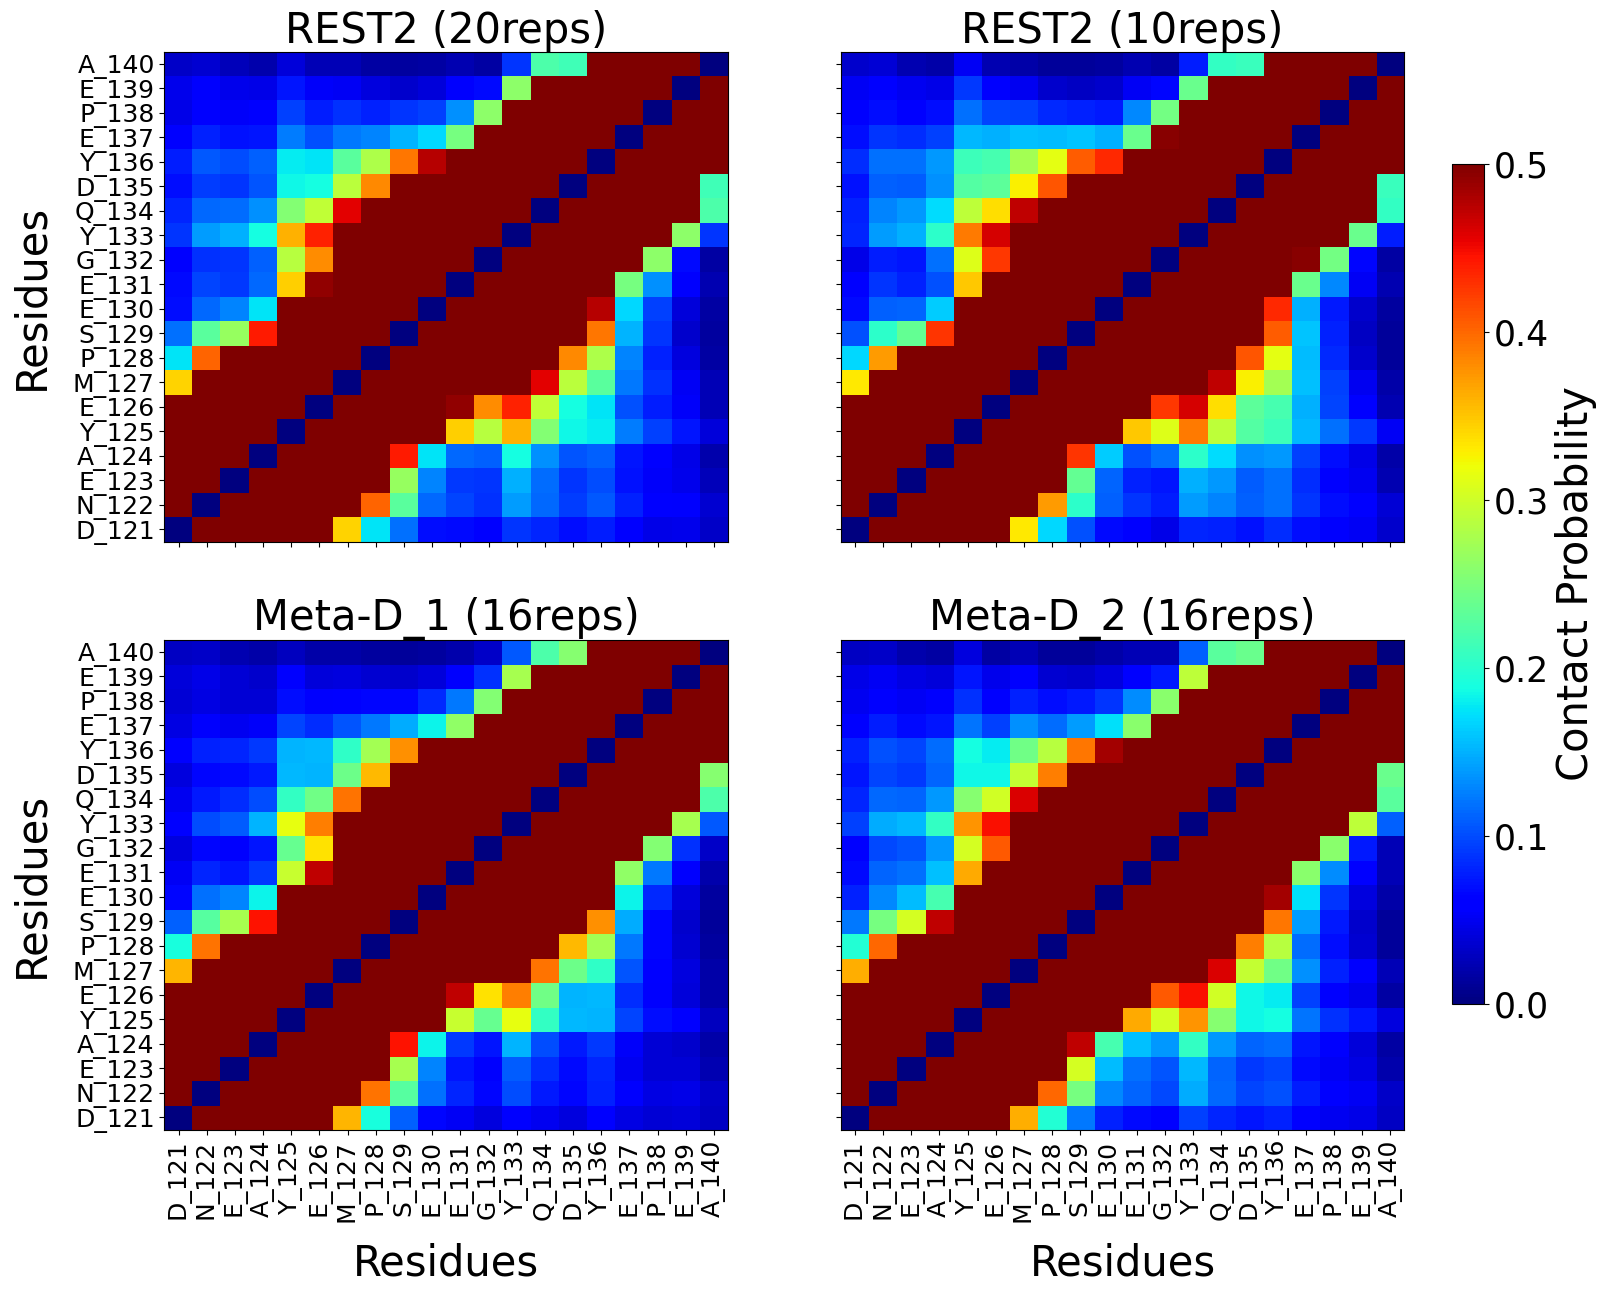

In [256]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig, axes = plt.subplots(2,2, figsize=(16,14), sharex=True, sharey=True)
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])

images=[]
for i in range(4):
    # ax.set_axis_off()

    if i>=2:
        contact_map = np.array(contact_map_p[i]['re'])
    else:
        contact_map = np.array(contact_map_p[i]['rep'])[0]
    p,q = np.unravel_index(i,(2,2))

    im = axes[p,q].imshow(contact_map, vmin=0, vmax=0.5,cmap='jet', aspect='auto')
    axes[p,q].invert_yaxis()
    axes[p,q].set_xticks(range(0, 20), b, rotation=90, size=18)
    axes[p,q].set_yticks(range(0, 20), b, rotation=0, size=18)
    axes[p,q].grid(False)
    axes[p,q].set_title(title_[i],size=30)

    if not q : axes[p,q].set_ylabel("Residues", size=30, labelpad=15)
    if p == 2-1 : axes[p,q].set_xlabel('Residues', size=30, labelpad=15)
    images.append(im)

cbar = fig.colorbar(images[-1],cax=cax)
cbar.set_label("Contact Probability", size=30)
cbar.ax.tick_params(labelsize=25)
# cbar.set_ticks([])
# cbar.set_ticklabels([])

# fig.text(0.5, 0.005, "Residues", ha="center", fontsize=30)
# fig.text(0.008, 0.5, "Residues", va="center", rotation="vertical", fontsize=30)


# plt.grid(alpha=0.1)
plt.show()

In [257]:
contact_map_l={}

p=0
for i in data_dir:
    
    contact_map_l[p]=json.load(open(i+'l_contact_map.json','r'))
    p+=1

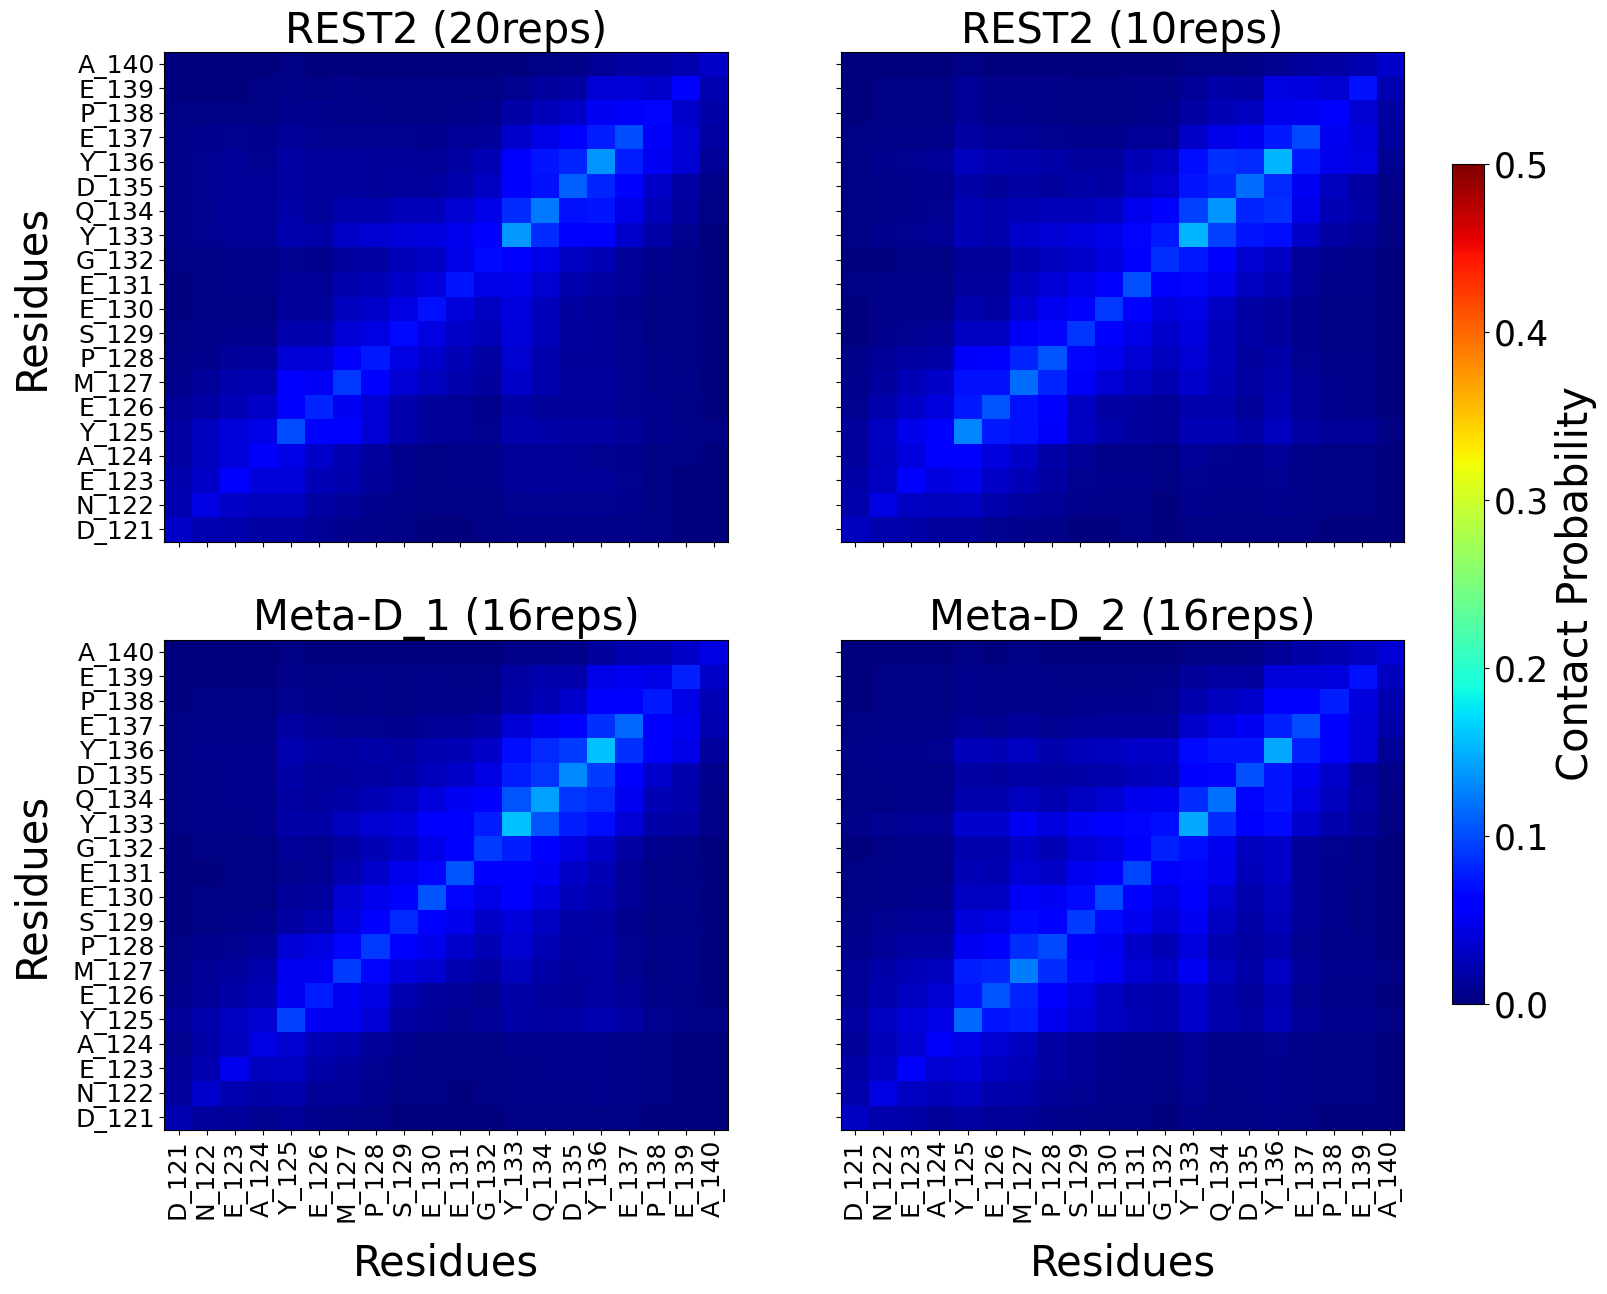

In [258]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig, axes = plt.subplots(2,2, figsize=(16,14), sharex=True, sharey=True)
cax= fig.add_axes([0.93, 0.2, 0.02, 0.6])
# cax= fig.add_axes([0.15, 0.00, 0.6, 0.02])

images=[]
for i in range(4):
    # ax.set_axis_off()

    if i>=2:
        contact_map = np.array(contact_map_l[i]['re'])
    else:
        contact_map = np.array(contact_map_l[i]['rep'])[0]
    p,q = np.unravel_index(i,(2,2))

    im = axes[p,q].imshow(contact_map, vmin=0, vmax=0.5,cmap='jet', aspect='auto')
    axes[p,q].invert_yaxis()
    axes[p,q].set_xticks(range(0, 20), b, rotation=90, size=18)
    axes[p,q].set_yticks(range(0, 20), b, rotation=0, size=18)
    axes[p,q].grid(False)
    axes[p,q].set_title(title_[i],size=30)

    if not q : axes[p,q].set_ylabel("Residues", size=30, labelpad=15)
    if p == 2-1 : axes[p,q].set_xlabel('Residues', size=30, labelpad=15)
    images.append(im)

cbar = fig.colorbar(images[-1],cax=cax) # , orientation="horizontal"
cbar.set_label("Contact Probability", size=30)
cbar.ax.tick_params(labelsize=25)
# cbar.set_ticks([])
# cbar.set_ticklabels([])

# fig.text(0.5, 0.005, "Residues", ha="center", fontsize=30)
# fig.text(0.008, 0.5, "Residues", va="center", rotation="vertical", fontsize=30)


# plt.grid(alpha=0.1)
plt.show()

In [259]:
data_dir[:-2]

['/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas_20reps/',
 '/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas/']

In [260]:
bf_kd={}

p=0
for i in data_dir[:-2]:
    
    bf_kd[p]=json.load(open(i+'bf_kd.json','r'))
    p+=1

In [261]:
nrep

[20, 10, 16, 16]

In [262]:
box_len=[6.428999900817871, 6.428999900817871]

temperature={}

temperature[0] = [ 300,311.147,322.707,334.697,347.133,360.031,373.408,387.282,401.671,416.595,
                  432.074,448.128,464.778,482.047,499.957,518.533,537.799,557.781,578.506,600 ]
temperature[1]=[ 300,313.825,328.286,343.414,359.239,375.794,393.111,411.227,430.177,450 ]


In [294]:
1-0.45

0.55

In [305]:
def dG_(bf:float=1.0,temperature:float=300.0):
    
    kb=0.001987
    
    dG = -kb*temperature*np.log(bf/float(1.0-bf))
        
    return dG

In [309]:
np.array(bf_kd[0]['rep'])[0][0]

array([0.39476842, 0.36637069, 0.34813215, 0.32133429, 0.31365491,
       0.29565635, 0.29293657, 0.2887769 , 0.28301736, 0.27733781,
       0.27733781, 0.28717703, 0.28389729, 0.2924566 , 0.30765539,
       0.31965443, 0.3312535 , 0.35013199, 0.36901048, 0.39612831])

In [310]:
dG_(0.39476842)

0.254720592091059

In [311]:
dG_(0.39612831)


0.2513298086870781

In [312]:
dG={}
dG_ue={}
dG_le={}

for i in range(2):
    fe=[]
    fe_ue=[]
    fe_le=[]
    
    
    for j in range(nrep[i]):
        
        g=dG_(np.array(bf_kd[i]['rep'])[0][0][j])
        gue=dG_(np.array(bf_kd[i]['rep'])[0][0][j]+np.array(bf_kd[i]['rep'])[1][0][j])
        gle=dG_(np.array(bf_kd[i]['rep'])[0][0][j]-np.array(bf_kd[i]['rep'])[1][0][j])
        
        fe.append(g)
        fe_ue.append(gue)
        fe_le.append(gle)
        
    
    dG[i]=np.array(fe)
    dG_ue[i]=np.array(fe_ue)
    dG_le[i]=np.array(fe_le)


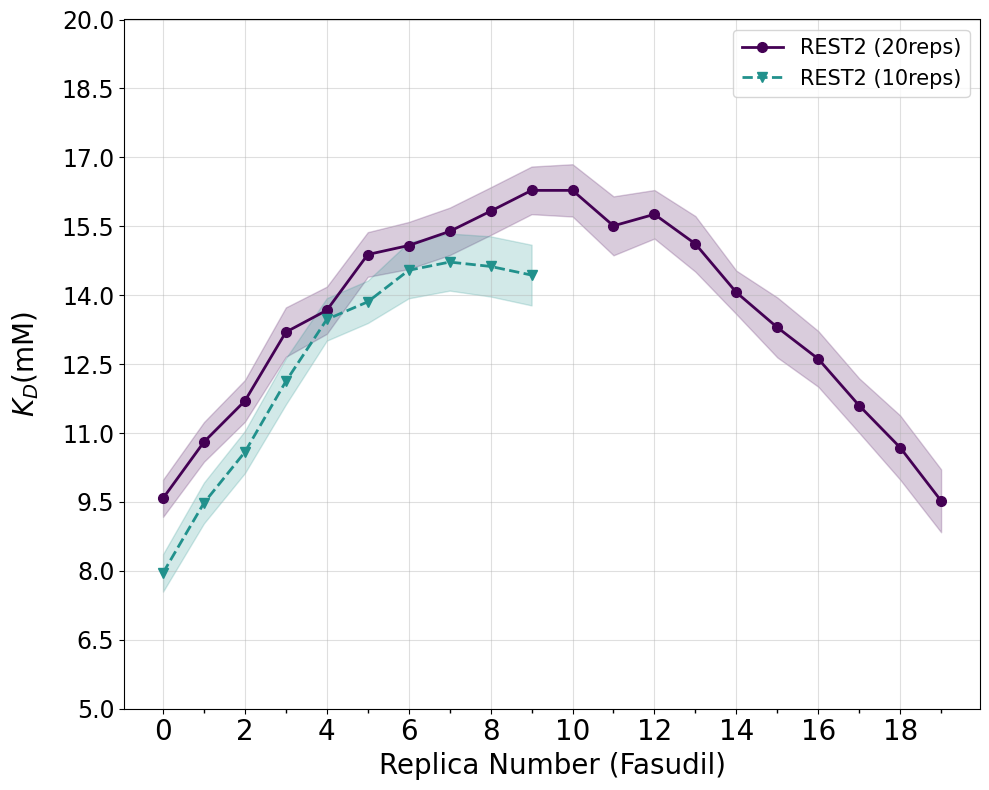

In [172]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$K_{D}$(mM)'

for i in range(2):
    
    plt.plot(range(nrep[i]),np.array(bf_kd[i]['rep'])[2][0],linestyle=linestyles[i % len(linestyles)],
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    plt.fill_between(range(nrep[i]), np.array(bf_kd[i]['rep'])[2][0]-np.array(bf_kd[i]['rep'])[3][0],
                 np.array(bf_kd[i]['rep'])[2][0]+np.array(bf_kd[i]['rep'])[3][0], color=plt.cm.viridis(i/2), alpha=0.2)
    
    
plt.xticks(range(0,20,2),size=20)
plt.xlabel('Replica Number (Fasudil)', fontsize=20)
plt.yticks(np.arange(5.0,20.6,1.5), rotation=0, size=17)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()



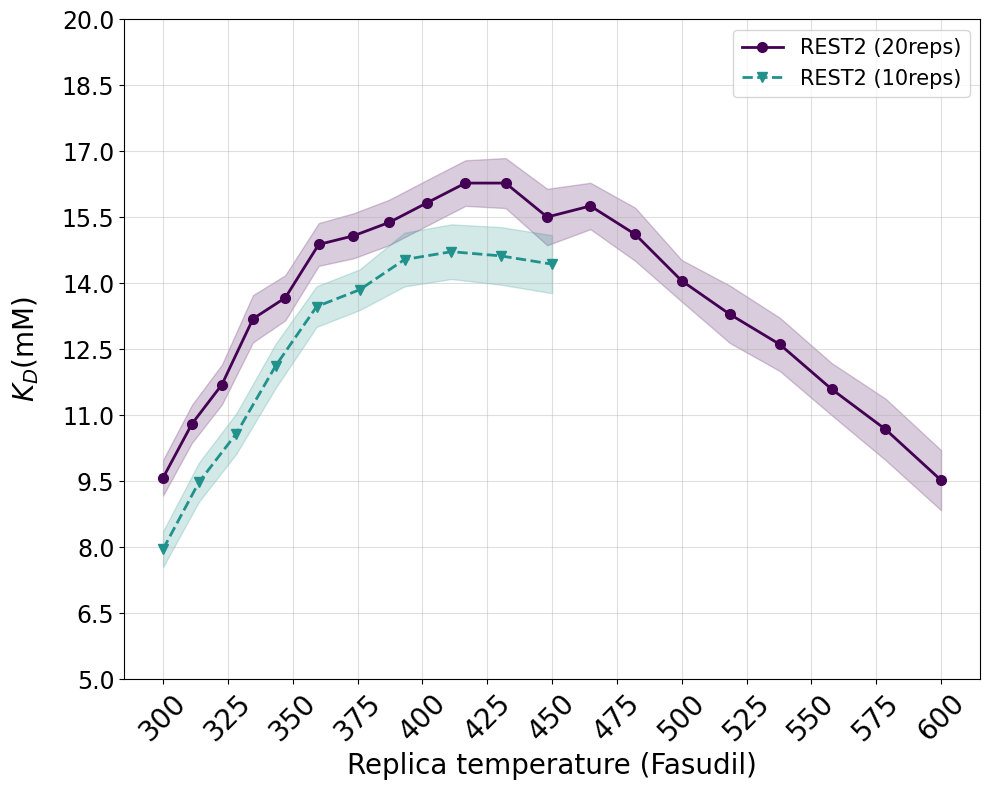

In [173]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$K_{D}$(mM)'

for i in range(2):
    
    plt.plot(temperature[i],np.array(bf_kd[i]['rep'])[2][0],linestyle=linestyles[i % len(linestyles)],
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    plt.fill_between(temperature[i], np.array(bf_kd[i]['rep'])[2][0]-np.array(bf_kd[i]['rep'])[3][0],
                 np.array(bf_kd[i]['rep'])[2][0]+np.array(bf_kd[i]['rep'])[3][0], color=plt.cm.viridis(i/2), alpha=0.2)
    
    
plt.xticks(range(300,625,25),size=20, rotation=45)
plt.xlabel('Replica temperature (Fasudil)', fontsize=20)
plt.yticks(np.arange(5.0,20.6,1.5), rotation=0, size=17)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


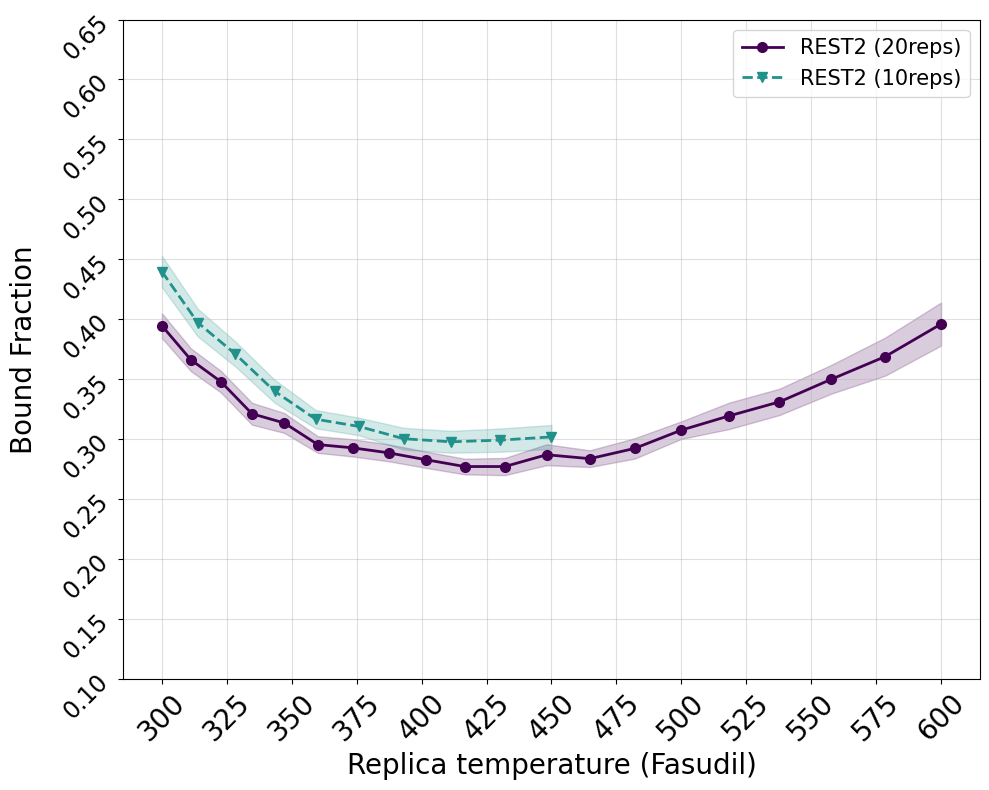

In [174]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'Bound Fraction'

for i in range(2):
    
    plt.plot(temperature[i],np.array(bf_kd[i]['rep'])[0][0],linestyle=linestyles[i % len(linestyles)],
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    plt.fill_between(temperature[i], np.array(bf_kd[i]['rep'])[0][0]-np.array(bf_kd[i]['rep'])[1][0],
                 np.array(bf_kd[i]['rep'])[0][0]+np.array(bf_kd[i]['rep'])[1][0], color=plt.cm.viridis(i/2), alpha=0.2)
    
    
plt.xticks(range(300,625,25),size=20, rotation=45)
plt.xlabel('Replica temperature (Fasudil)', fontsize=20)
plt.yticks(np.arange(0.1,0.66,0.05), rotation=45, size=17)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


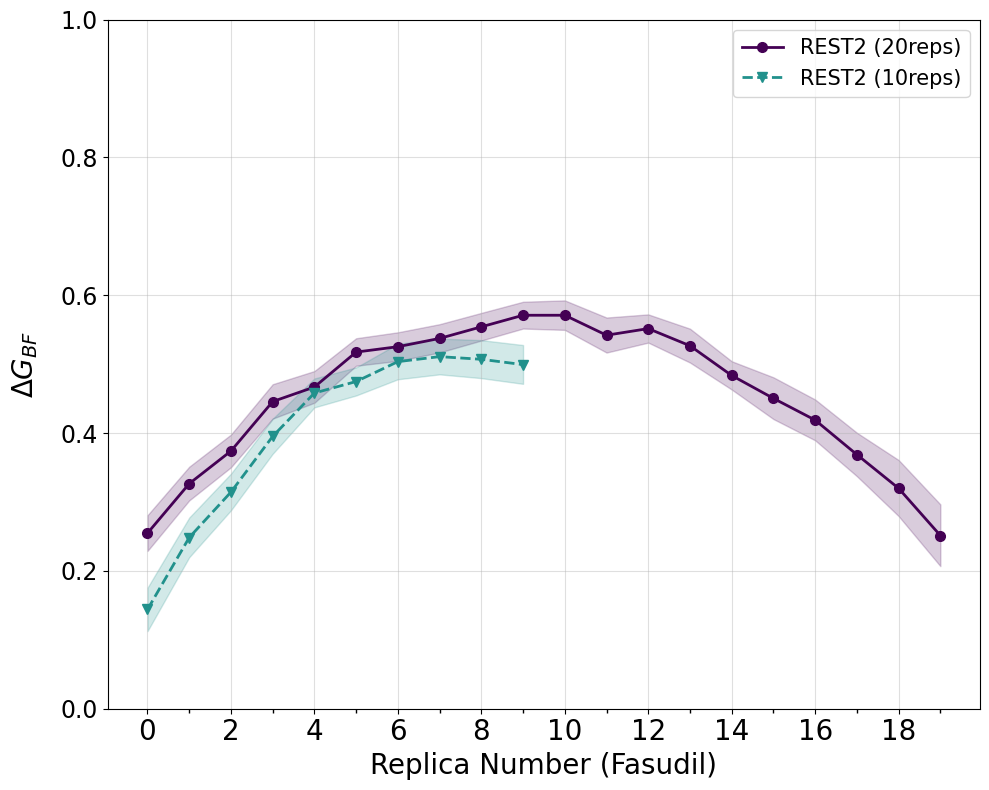

In [313]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$\Delta G_{BF}$'

for i in range(2):
    
    plt.plot(range(nrep[i]),dG[i],linestyle=linestyles[i % len(linestyles)],marker=marker[i % len(marker)],
             color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    
    plt.fill_between(range(nrep[i]), dG_le[i],
                     dG_ue[i], color=plt.cm.viridis(i/2), alpha=0.2)
    
plt.xticks(range(0,20,2),size=20, rotation=0)
plt.xlabel('Replica Number (Fasudil)', fontsize=20)
plt.yticks(np.arange(0,1.2,0.2), size=17)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


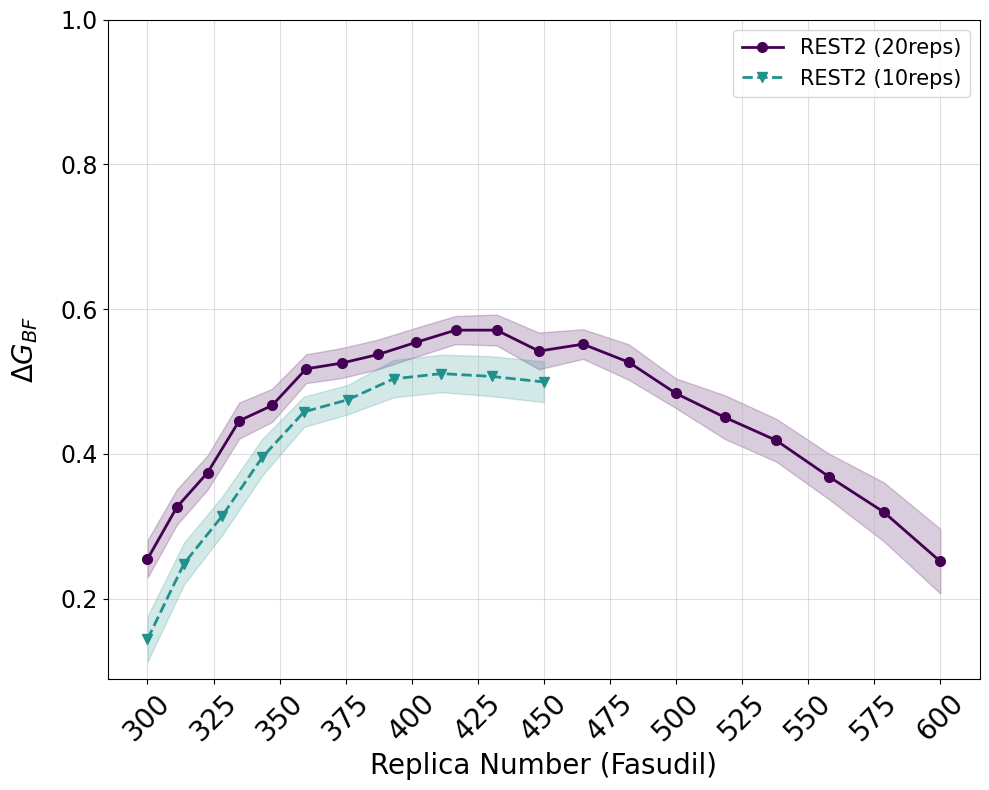

In [314]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$\Delta G_{BF}$'

for i in range(2):
    
    plt.plot(temperature[i],dG[i],linestyle=linestyles[i % len(linestyles)],marker=marker[i % len(marker)],
             color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    
    plt.fill_between(temperature[i], dG_le[i],
                     dG_ue[i], color=plt.cm.viridis(i/2), alpha=0.2)
    
plt.xticks(range(300,625,25),size=20, rotation=45)
plt.xlabel('Replica Number (Fasudil)', fontsize=20)
plt.yticks(np.arange(0.2,1.2,0.2), size=17)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


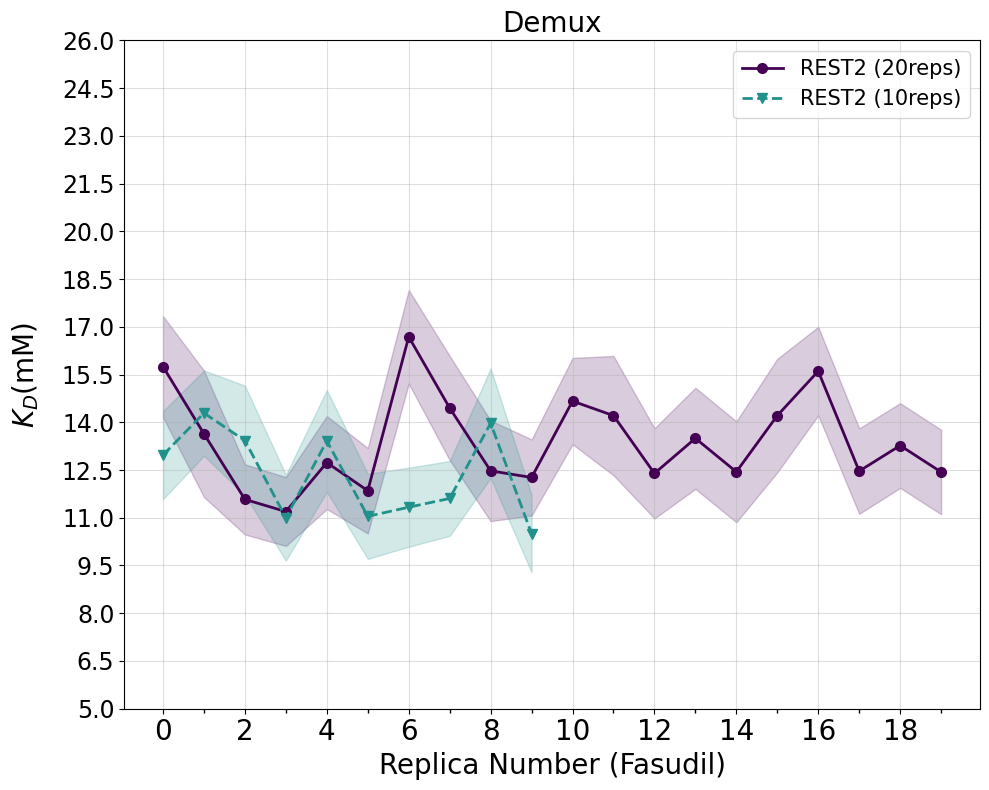

In [180]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$K_{D}$(mM)'

for i in range(2):
    
    plt.plot(range(nrep[i]),np.array(bf_kd[i]['demux'])[2][0],linestyle=linestyles[i % len(linestyles)],
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    plt.fill_between(range(nrep[i]), np.array(bf_kd[i]['demux'])[2][0]-np.array(bf_kd[i]['demux'])[3][0],
                 np.array(bf_kd[i]['demux'])[2][0]+np.array(bf_kd[i]['demux'])[3][0], color=plt.cm.viridis(i/2), alpha=0.2)
    
    
plt.xticks(range(0,20,2),size=20)
plt.xlabel('Replica Number (Fasudil)', fontsize=20)
plt.yticks(np.arange(5.0,26.6,1.5), rotation=0, size=17)
plt.grid(alpha=0.4)
plt.title("Demux",fontsize=20)
# Add minor ticks only on x-axis
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


In [315]:
dG={}
dG_ue={}
dG_le={}

for i in range(2):
    fe=[]
    fe_ue=[]
    fe_le=[]
    
    
    for j in range(nrep[i]):
        
        g=dG_(np.array(bf_kd[i]['demux'])[0][0][j])
        gue=dG_(np.array(bf_kd[i]['demux'])[0][0][j]+np.array(bf_kd[i]['demux'])[1][0][j])
        gle=dG_(np.array(bf_kd[i]['demux'])[0][0][j]-np.array(bf_kd[i]['demux'])[1][0][j])
        
        fe.append(g)
        fe_ue.append(gue)
        fe_le.append(gle)
        
    
    dG[i]=np.array(fe)
    dG_ue[i]=np.array(fe_ue)
    dG_le[i]=np.array(fe_le)


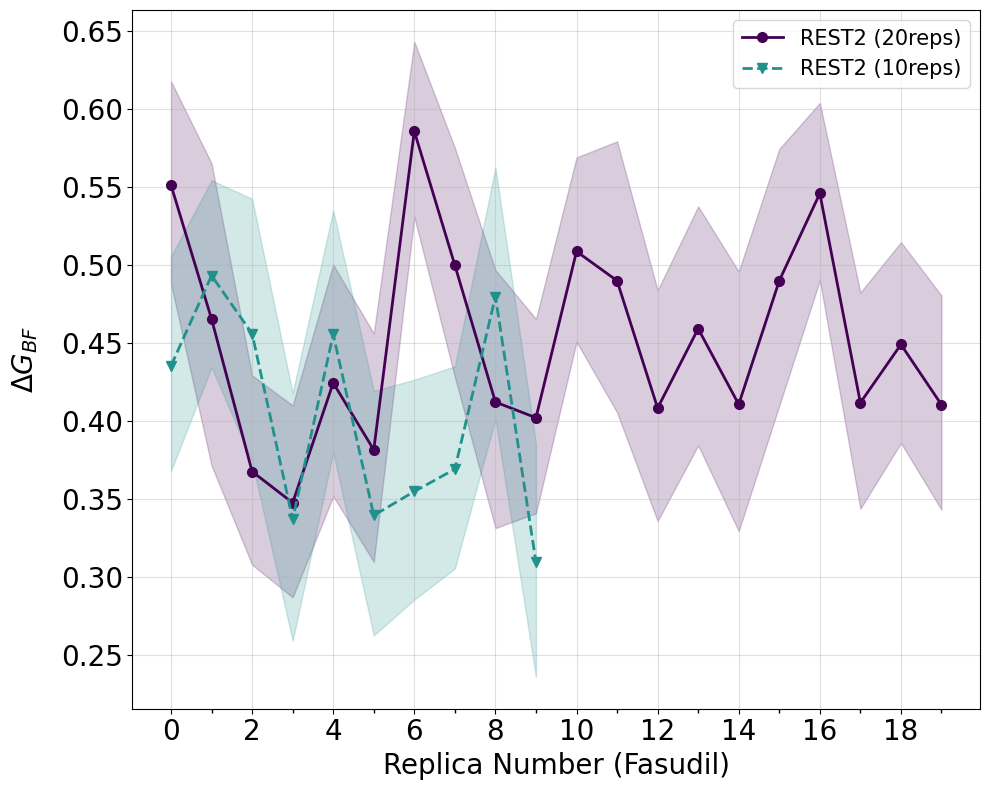

In [316]:
linestyles = ['-', '--', '-.', ':','dotted']
marker=['o','v','<','^','>']
plt.figure(figsize=(10,8))
yl=r'$\Delta G_{BF}$'

for i in range(2):
    
    plt.plot(range(nrep[i]),dG[i],linestyle=linestyles[i % len(linestyles)],marker=marker[i % len(marker)],
             color=plt.cm.viridis(i/2), lw=2, ms=7,label=title_[i])
    
    plt.fill_between(range(nrep[i]), dG_le[i],
                     dG_ue[i], color=plt.cm.viridis(i/2), alpha=0.2)
    
plt.xticks(range(0,20,2),size=20, rotation=0)
plt.xlabel('Replica Number (Fasudil)', fontsize=20)
plt.yticks(size=20)
plt.grid(alpha=0.4)

# Add minor ticks only on x-axis
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.legend(fontsize=15)    
plt.ylabel(yl, size=20, labelpad=15)
plt.tight_layout()


In [184]:
ss={}
sa={}
pp={}
rg={}

p=0
for i in data_dir[:-2]:
    
    ss[p]=json.load(open(i+'ss_fraction.json','r'))
    sa[p]=json.load(open(i+'sa_timeseries.json','r'))
    pp[p]=json.load(open(i+'pp_timeseries.json','r'))
    rg[p]=json.load(open(i+'rg_timeseries.json','r'))
    
    p+=1

In [185]:
a=[1, 2]
print(np.prod(a))

for i in range(np.prod(a)):

    row, col = divmod(i, a[1])  # Calculate row and column index
    print(row, col)
print("\n")
for i in range(np.prod(a)):
    p, q = np.unravel_index(i,(a))
    print(p,q)

2
0 0
0 1


0 0
0 1


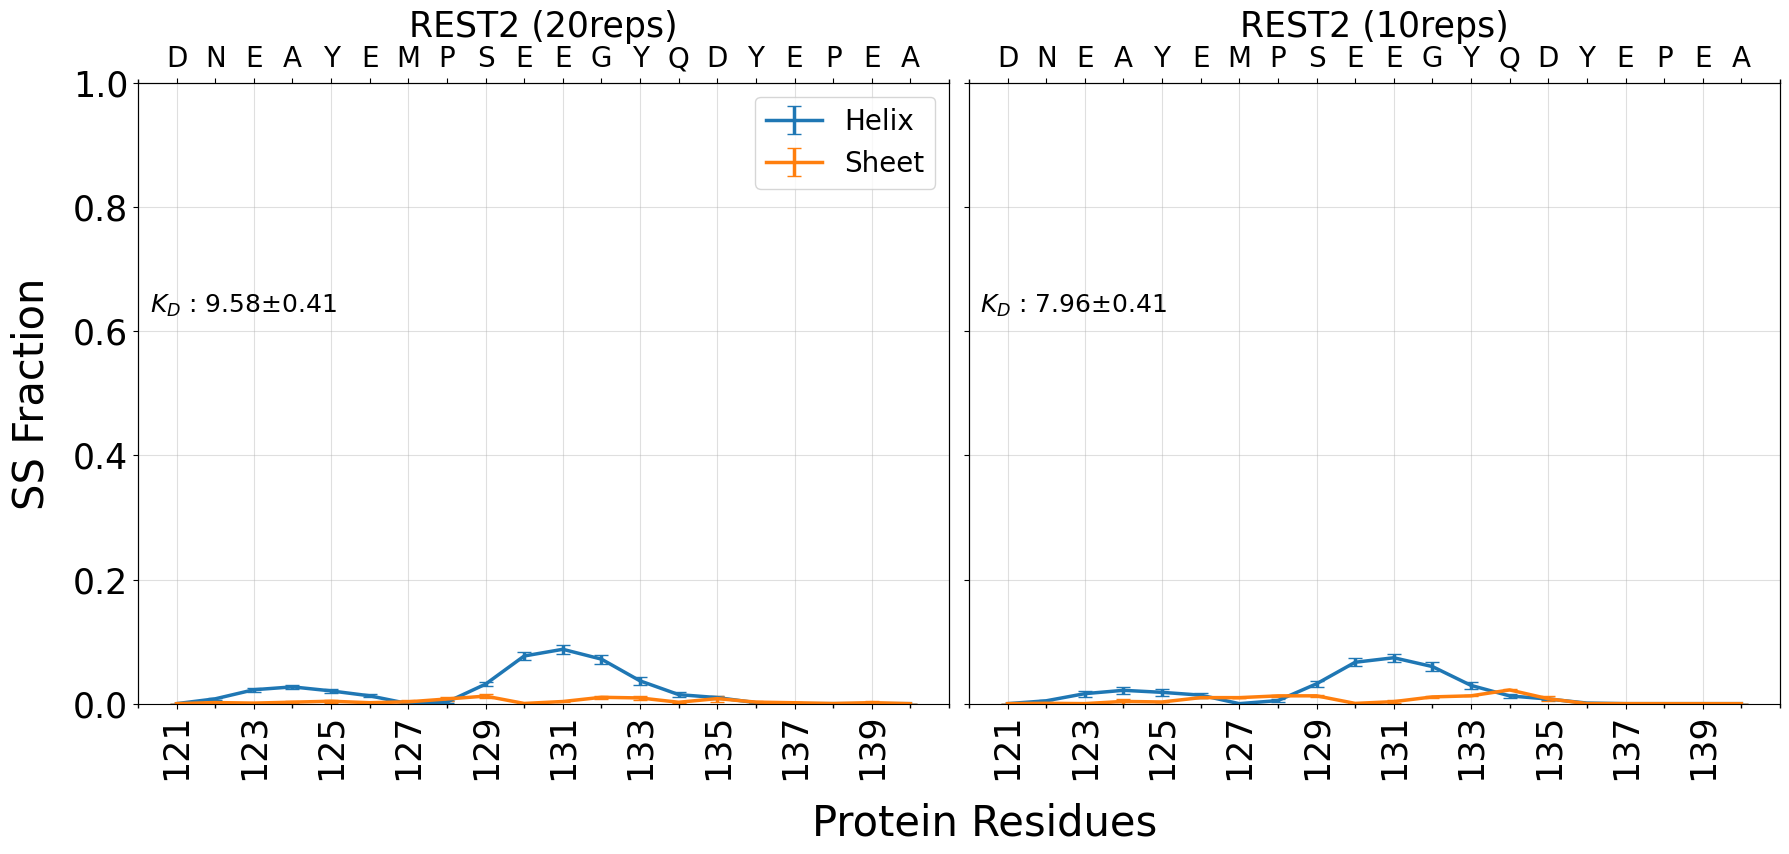

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

for val in range(2):
    
    p, q = np.unravel_index(val,(1, 2))
    
    ax[val].errorbar(range(121, 141),np.array(ss[val]['rep']['helix'])[0].T[0],
                     yerr=np.array(ss[val]['rep']['helix'])[0].T[1], capsize=5,label='Helix',linewidth=2.5)
    ax[val].errorbar(range(121, 141),np.array(ss[val]['rep']['sheet'])[0].T[0],
                     yerr=np.array(ss[val]['rep']['sheet'])[0].T[1], capsize=5,label='Sheet',linewidth=2.5)
    
    ax[val].tick_params(labelsize=25)
    ax[val].grid(alpha=0.4)
    plt.setp(ax[val].get_xticklabels(), rotation=90)
    ax[val].set_ylim(0,1.0)
    ax[val].set_xlim(120,141)
    # ax[val].set_xticks(range(121,141,2), b[::2])
    ax[val].set_xticks(range(121,141,2), range(121,141,2),rotation=90)

    ax[val].set_title(title_[val],size=25)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax[val].tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

    ax2 = ax[val].twiny()

    # Set custom labels for the top x-axis
    top_labels = c[::2]
    top_tick_positions = range(0, 20, 2)

    # Use invisible spines and set labels for the top x-axis
    ax2.spines['top'].set_position(('outward', 0))
    ax2.spines['top'].set_visible(True)
    ax2.spines['bottom'].set_position(('outward', 0))
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xlim(120,141)
    ax2.set_xticks(range(121,141), c[::])
    # ax2.set_xticklabels(top_labels)
    ax2.tick_params(axis='x', labelsize=20)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')
    
    if val == 0:
        ax[val].legend(loc=1,prop={'size': 20})
    
    if not q : ax[val].set_ylabel("SS Fraction", size=30, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel('Protein Residues', size=30, labelpad=15)
    
    if val <= 2 :
        
        text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[val]['rep'])[2][0][0],2))+\
        r'$\pm$'+str(round(np.array(bf_kd[val]['rep'])[3][0][0],2))
    else :
        text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[val]['rep'])[2][0][0],2))+\
        r'$\pm$'+str(round(np.array(bf_kd[val]['rep'])[3][0][0],2))
    
    ax[val].text(120.3, 0.63, text_, fontsize = 18)

fig.text(0.55, -0.05, 'Protein Residues', ha='center', size=30)


plt.tight_layout()
# plt.savefig(data_dir+'ss_fraction_rep.png',dpi=210)


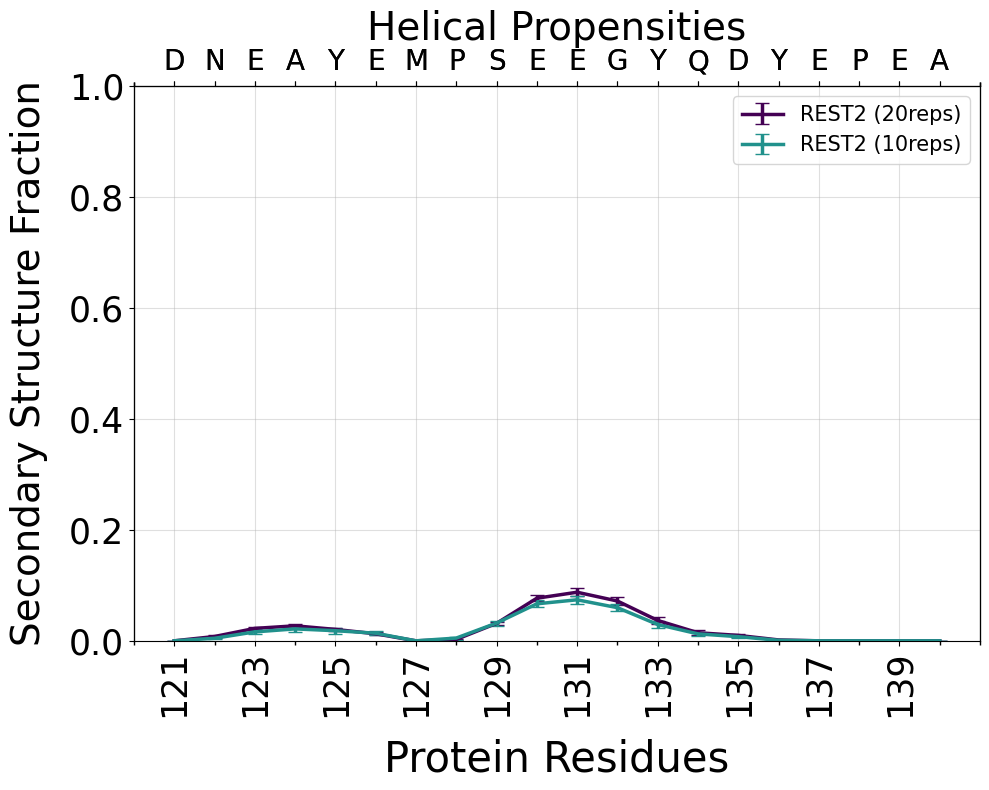

In [188]:
fig, axes = plt.subplots(1,1,figsize=(10,8))

for val in range(2):
    
    axes.errorbar(range(121, 141),np.array(ss[val]['rep']['helix'])[0].T[0],yerr=np.array(ss[val]['rep']['helix'])[0].T[1],
                 capsize=5,label=title_[val],linewidth=2.5,c=plt.cm.viridis(val/2))
    
    axes.tick_params(labelsize=25)
    axes.grid(alpha=0.4)
    plt.setp(ax[val].get_xticklabels(), rotation=90)
    axes.set_ylim(0,1.0)
    axes.set_xlim(120,141)
    # ax[val].set_xticks(range(121,141,2), b[::2])
    axes.set_xticks(range(121,141,2), range(121,141,2),rotation=90)
    axes.legend( fontsize=15) 
    axes.set_ylabel("Secondary Structure Fraction", size=28, labelpad=15)
    axes.set_xlabel('Protein Residues', size=30, labelpad=15)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    axes.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

    ax2 = axes.twiny()

    # Set custom labels for the top x-axis
    top_labels = c[::2]
    top_tick_positions = range(0, 20, 2)

    # Use invisible spines and set labels for the top x-axis
    ax2.spines['top'].set_position(('outward', 0))
    ax2.spines['top'].set_visible(True)
    ax2.spines['bottom'].set_position(('outward', 0))
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xlim(120,141)
    ax2.set_xticks(range(121,141), c[::])
    # ax2.set_xticklabels(top_labels)
    ax2.tick_params(axis='x', labelsize=20)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.title('Helical Propensities',size=28) 

    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
# plt.savefig(data_dir+'ss_fraction_helix_rep.png',dpi=210)

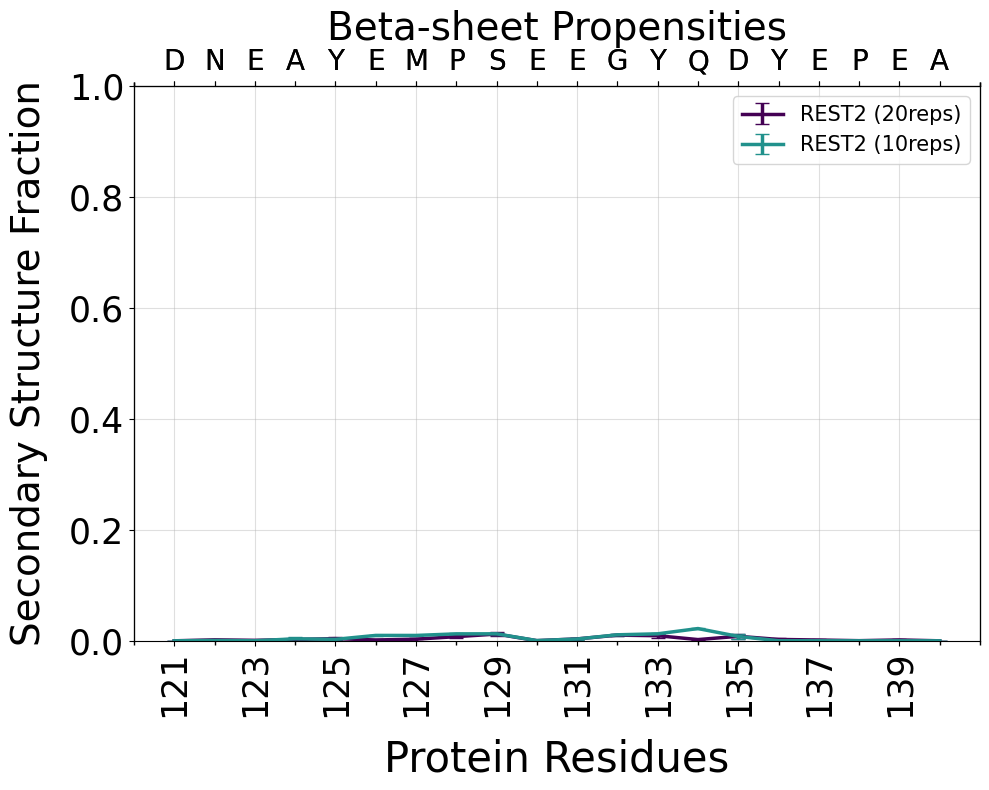

In [189]:
fig, axes = plt.subplots(1,1,figsize=(10,8))

for val in range(2):
    
    axes.errorbar(range(121, 141),np.array(ss[val]['rep']['sheet'])[0].T[0],yerr=np.array(ss[val]['rep']['sheet'])[0].T[1],
                 capsize=5,label=title_[val],linewidth=2.5,c=plt.cm.viridis(val/2))
    
    axes.tick_params(labelsize=25)
    axes.grid(alpha=0.4)
    plt.setp(ax[val].get_xticklabels(), rotation=90)
    axes.set_ylim(0,1.0)
    axes.set_xlim(120,141)
    # ax[val].set_xticks(range(121,141,2), b[::2])
    axes.set_xticks(range(121,141,2), range(121,141,2),rotation=90)
    axes.legend( fontsize=15) 
    axes.set_ylabel("Secondary Structure Fraction", size=28, labelpad=15)
    axes.set_xlabel('Protein Residues', size=30, labelpad=15)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    axes.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

    ax2 = axes.twiny()

    # Set custom labels for the top x-axis
    top_labels = c[::2]
    top_tick_positions = range(0, 20, 2)

    # Use invisible spines and set labels for the top x-axis
    ax2.spines['top'].set_position(('outward', 0))
    ax2.spines['top'].set_visible(True)
    ax2.spines['bottom'].set_position(('outward', 0))
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xlim(120,141)
    ax2.set_xticks(range(121,141), c[::])
    # ax2.set_xticklabels(top_labels)
    ax2.tick_params(axis='x', labelsize=20)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

plt.title('Beta-sheet Propensities',size=28) 

    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
# plt.savefig(data_dir+'ss_fraction_helix_rep.png',dpi=210)

In [190]:
phipsi={}

p=0
for i in data_dir[:-2]:
    
    phipsi[p]=json.load(open(i+'phipsi.json','r'))
    
    p+=1

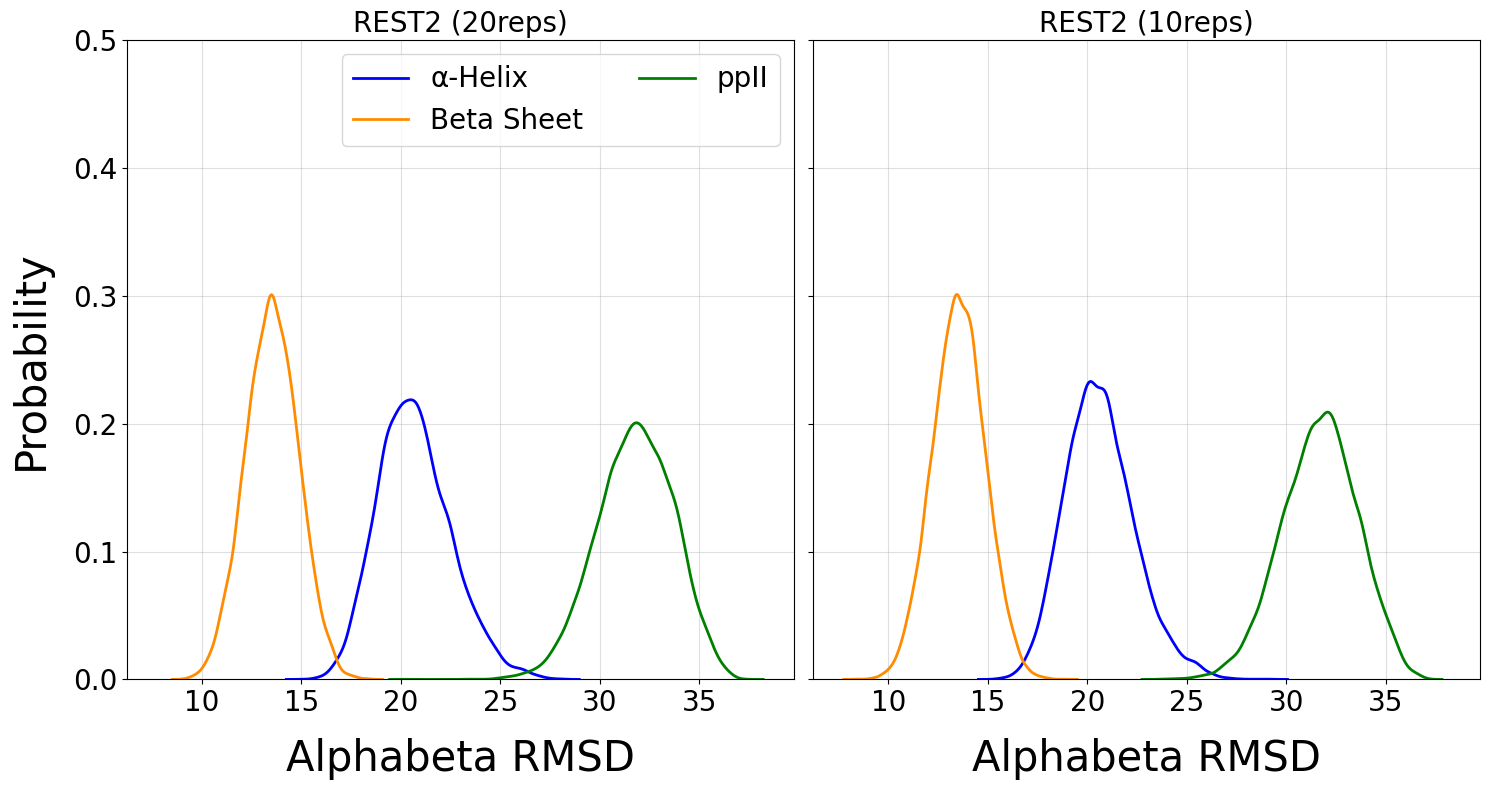

In [191]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)


for val in range(2):
    p, q = np.unravel_index(val,(1, 2))
    
    sns.kdeplot(data=np.array(phipsi[val]['rep'])[0][0], label='α-Helix',ax=ax[val], linewidth=2,c='b')
    sns.kdeplot(data=np.array(phipsi[val]['rep'])[0][1], label='Beta Sheet',ax=ax[val], linewidth=2,c='darkorange')
    sns.kdeplot(data=np.array(phipsi[val]['rep'])[0][2], label='ppII',ax=ax[val], linewidth=2,c='g')

    
    ax[val].set_ylim(0,0.5)
    #ax[p, q].set_xticks(range(121,142,2))
    ax[val].tick_params(labelsize=20)
    ax[val].grid(alpha=0.4)
    plt.setp(ax[val].get_xticklabels(), rotation=0)
    
    if val == 0:
        ax[val].legend(loc=1,prop={'size': 20},ncol=2)

    ax[val].set_title(title_[val],size=20)
    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.43, text_, fontsize = 26)
    
    if not q : ax[val].set_ylabel("Probability", size=30, labelpad=15)
    if p == 1-1 : ax[val].set_xlabel('Alphabeta RMSD', size=30, labelpad=15)
        


        
plt.tight_layout()

# plt.savefig(data_dir+'ss_rmsd_rep.png',dpi=210)


In [192]:
kd_time={}

p=0
for i in data_dir[:-2]:
    
    kd_time[p]=json.load(open(i+'kd_timecourse.json','r'))
    
    p+=1

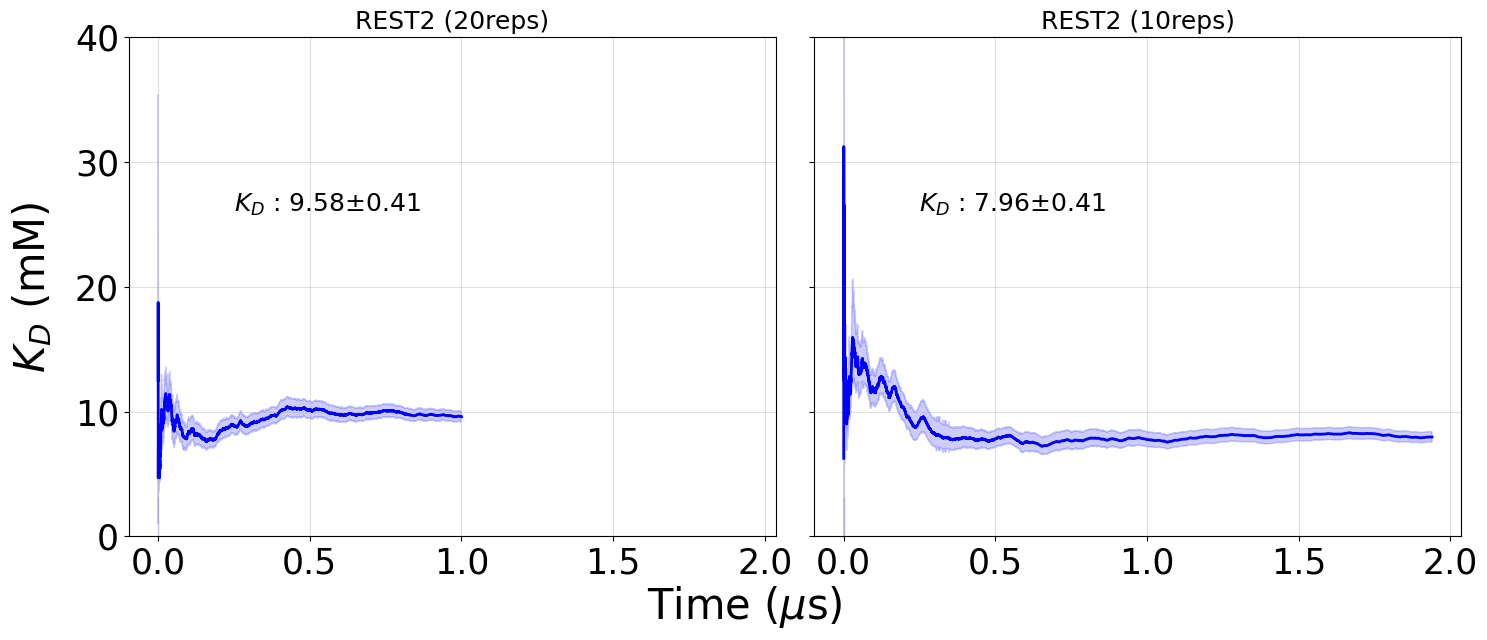

In [247]:
fig, ax = plt.subplots(1,2, figsize=(15, 6), sharex=True, sharey=True)

i='rep'

for val in range(2):
    p, q = np.unravel_index(val,(1,2))
    
    inf_start=len(np.where(np.array(kd_time[val][i])[0].T[4]==0)[0])

    ax[val].plot(np.array(kd_time[val][i])[0].T[0][inf_start::], np.array(kd_time[val][i])[0].T[1][inf_start::], 
                 color='blue',linewidth=2)
    ax[val].fill_between(np.array(kd_time[val][i])[0].T[0][inf_start::],np.array(kd_time[val][i])[0].T[2][inf_start::], 
                     np.array(kd_time[val][i])[0].T[3][inf_start::],color='blue', alpha=0.2)

    

    ax[val].grid(alpha=0.4)
    ax[val].set_ylim(0, 40.0)
    ax[val].tick_params(labelsize=25)
    #plt.setp(ax[p,q].get_xticklabels(), rotation=45)
    
#     a='Replica : '+str(temperature[val])+'K'
    ax[val].set_title(title_[val],size=18)
    
    if val <= 2 :
        
        text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[val]['rep'])[2][0][0],2))+\
        r'$\pm$'+str(round(np.array(bf_kd[val]['rep'])[3][0][0],2))
    else :
        text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[val]['rep'])[2][0][0],2))+\
        r'$\pm$'+str(round(np.array(bf_kd[val]['rep'])[3][0][0],2))
    
    ax[val].text(0.25, 26, text_, fontsize = 18)
    
    if not q : ax[val].set_ylabel('$K_D$ (mM)', size=30, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel('Time ($\mu$s)', size=20, labelpad=15)
        
fig.text(0.5, -0.04, 'Time ($\mu$s)', ha='center', size=30)

plt.tight_layout()

# plt.savefig(data_dir+'kd_timecourse.png',dpi=210)

In [194]:
def dG_1(kd=[],temperature=300.0,box_len=None):
        
    Box_L = box_len
    Box_V = (Box_L*10**-9)**3
    Box_V_L = Box_V*1000
    Concentration = 1/(Box_V_L*(6.023*10**23))

    dG=(0.001987*temperature)*np.log(kd/Concentration)
        
    return dG

In [195]:
time={}
for i in range(2):

    time[i]=np.insert(np.array(kd_time[i]['rep'])[0].T[0],0,0.00)


In [196]:

def norm_weights(file_name):

    colvar=np.loadtxt(file_name,comments=['#','@'])
    num_cvs=len(colvar[0])-1



    kt=2.494339
    w=np.exp((colvar[:,num_cvs]/kt))


    max_=np.sum(w)
    w_norm=w/max_

    return num_cvs, w, w_norm

In [197]:
print('Meta-Dynamics Weights')
weights_norm={}
colvar={}

file_1='/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/colvar/colvar_as_fas.dat'
file_2='/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/colvar/colvar_as_fas_1.dat'

num_cvs_1, weights_1, weights_norm['combined_1'] = norm_weights(file_1)
num_cvs_2, weights_2, weights_norm['combined_2'] = norm_weights(file_2)

print("No of CV's :", (num_cvs_1-1,num_cvs_2-1))
print(f"Sum of combined xtc : {np.sum(weights_norm['combined_1'])} , {np.sum(weights_norm['combined_2'])}")

colvar['combined_1']=np.loadtxt(file_1,comments=['@','#'])
colvar['combined_2']=np.loadtxt(file_2,comments=['@','#'])

Meta-Dynamics Weights
No of CV's : (12, 12)
Sum of combined xtc : 1.0 , 1.0000000000000004


In [123]:
trj_dict={}
top_dict={}

pdb_md3 = '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/prot_fas.pdb'
xtc_md3 = '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/prot_fas.xtc'

trj_dict['combined'] = md.load(xtc_md3, top=pdb_md3, stride=1)
trj_dict['combined'].center_coordinates()
top_dict['combined'] = trj_dict['combined'].topology

print(trj_dict['combined'].n_frames)

nreps=16

t=((trj_dict['combined'].n_frames-1)/16)
a=0
b=t
trj_frames={}
trj_frames['combined_1']={}
for i in range(16):
    #print([i, a, b])
    trj_frames['combined_1'][i]= [a,b]
    a=b
    b=b+t
    
    
del a; del b;

del trj_dict ; del top_dict

1600001


In [124]:
trj_dict={}
top_dict={}

pdb_md3 = '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/prot_fas.pdb'
xtc_md3 = '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/prot_fas_1.xtc'

trj_dict['combined'] = md.load(xtc_md3, top=pdb_md3, stride=1)
trj_dict['combined'].center_coordinates()
top_dict['combined'] = trj_dict['combined'].topology

print(trj_dict['combined'].n_frames)

nreps=16

t=((trj_dict['combined'].n_frames-1)/16)
a=0
b=t
trj_frames['combined_2']={}
for i in range(16):
    #print([i, a, b])
    trj_frames['combined_2'][i]= [a,b]
    a=b
    b=b+t
    
    
del a; del b;

del trj_dict ; del top_dict

1600001


/tmp/ipykernel_4281/1901886420.py:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i,0].get_shared_y_axes().join(ax[i,0],ax[i,1])


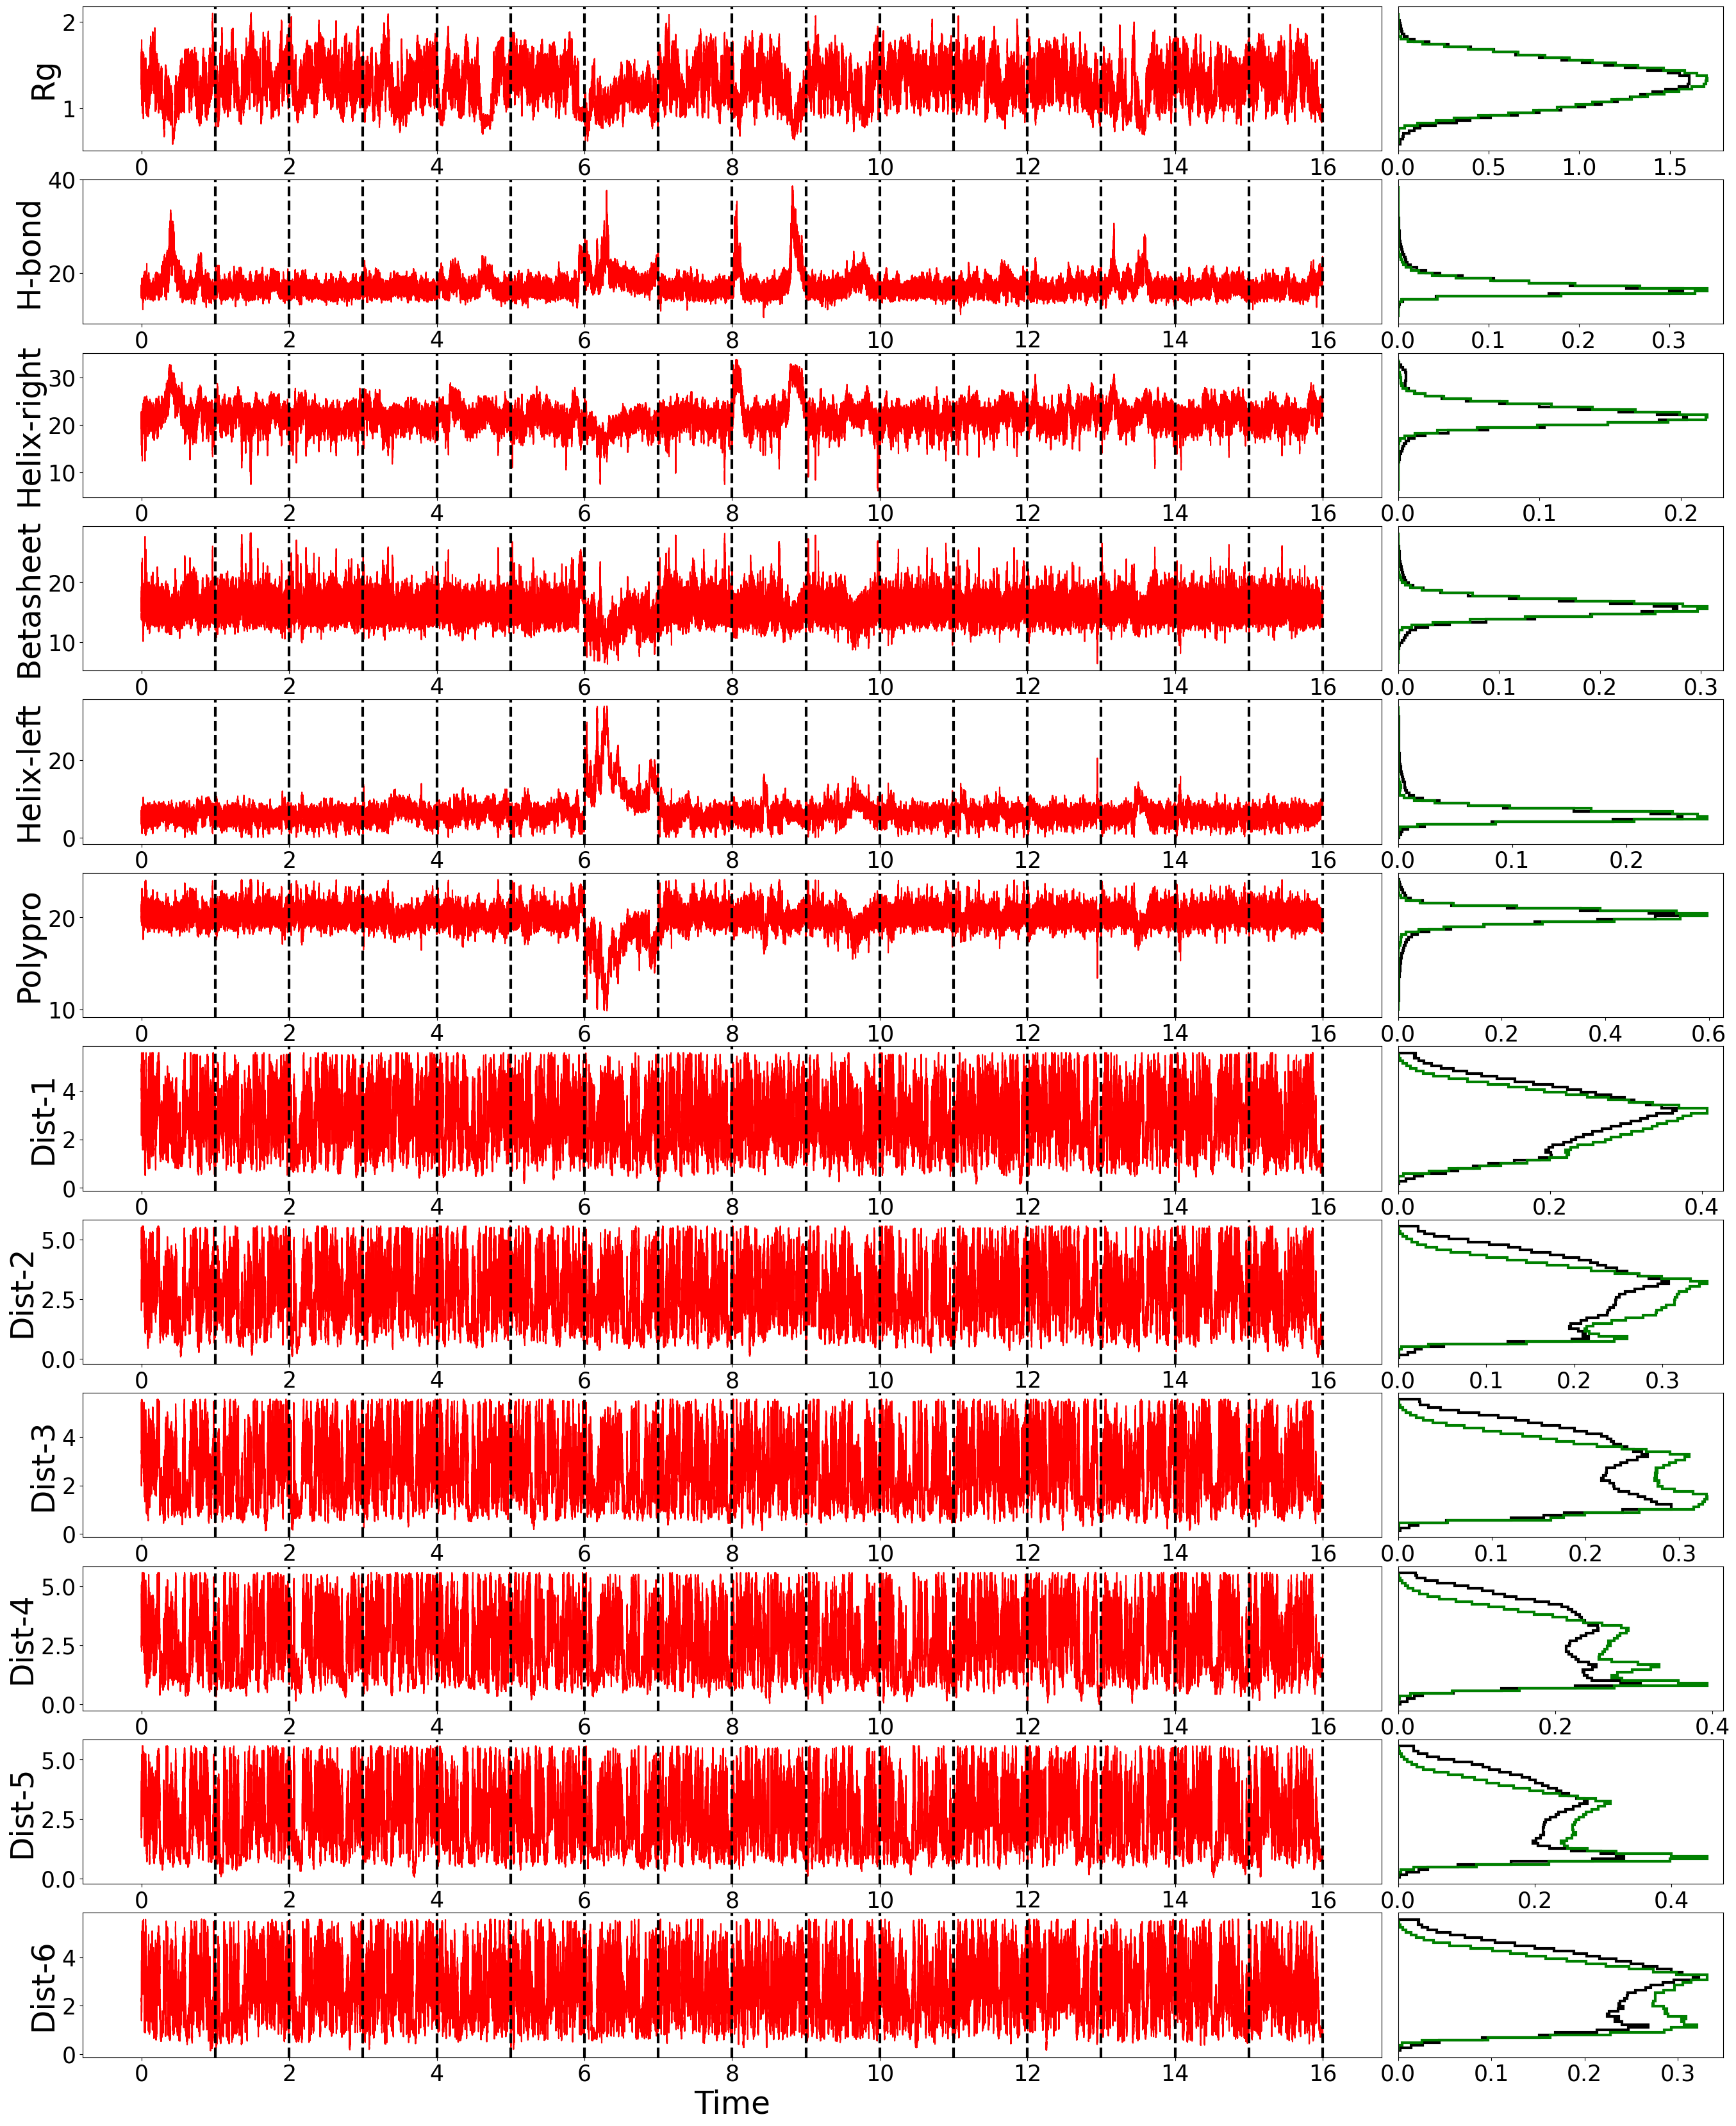

In [125]:

height_=[1]*(num_cvs_1-1)

label={'1':'Rg', '2':'H-bond', '3':'Helix-right', '4':'Betasheet', '5':'Helix-left', '6':'Polypro',
       '7':'Dist-1', '8':'Dist-2', '9':'Dist-3', '10':'Dist-4', '11':'Dist-5', '12':'Dist-6'}

f, ax = plt.subplots(num_cvs_1-1,2,figsize=(32,40),
                     gridspec_kw={'width_ratios':[4,1], 'height_ratios':height_, 'left':0.1, 'right':0.9, 
                                  'bottom':0.1, 'top':0.9,'wspace':0.02, 'hspace':0.2},sharey=False)

for i in range(num_cvs_1-1):
    

        
    ax[i,0].get_shared_y_axes().join(ax[i,0],ax[i,1])
    ax[i,0].plot(colvar['combined_1'].T[0]/10**5, colvar['combined_1'].T[i+1],color='r')
#    ax[i,0].set_ylim((min(colvar.T[i+1])-0.2),(max(colvar.T[i+1])+0.2))
    ax[i,0].set_ylabel(label[str(i+1)],size=35)
    ax[i,0].set_xlabel("Time",size=35)
    ax[i,0].tick_params(labelsize=25)
    
    for j in range(16):
        ax[i,0].axvline(x=trj_frames['combined_1'][j][1]/10**5, color='black', linewidth=3, linestyle='--')
    
    ax[i,1].hist(colvar['combined_1'].T[i+1],orientation='horizontal',bins=50,density=True,
                 color='black',histtype='step',linewidth=3)
    ax[i,1].hist(colvar['combined_1'].T[i+1],orientation='horizontal',bins=50,density=True,
                 color='green',histtype='step',linewidth=3,weights=weights_norm['combined_1'])
#    ax[i,1].set_xlim(0,0.7)
    ax[i,1].set_yticks([])
    ax[i,1].tick_params(labelsize=25)
    
#plt.tight_layout()

#plt.savefig(out_dir+'cv_plot.png',dpi=310)

plt.show()

/tmp/ipykernel_4281/1519072802.py:14: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i,0].get_shared_y_axes().join(ax[i,0],ax[i,1])


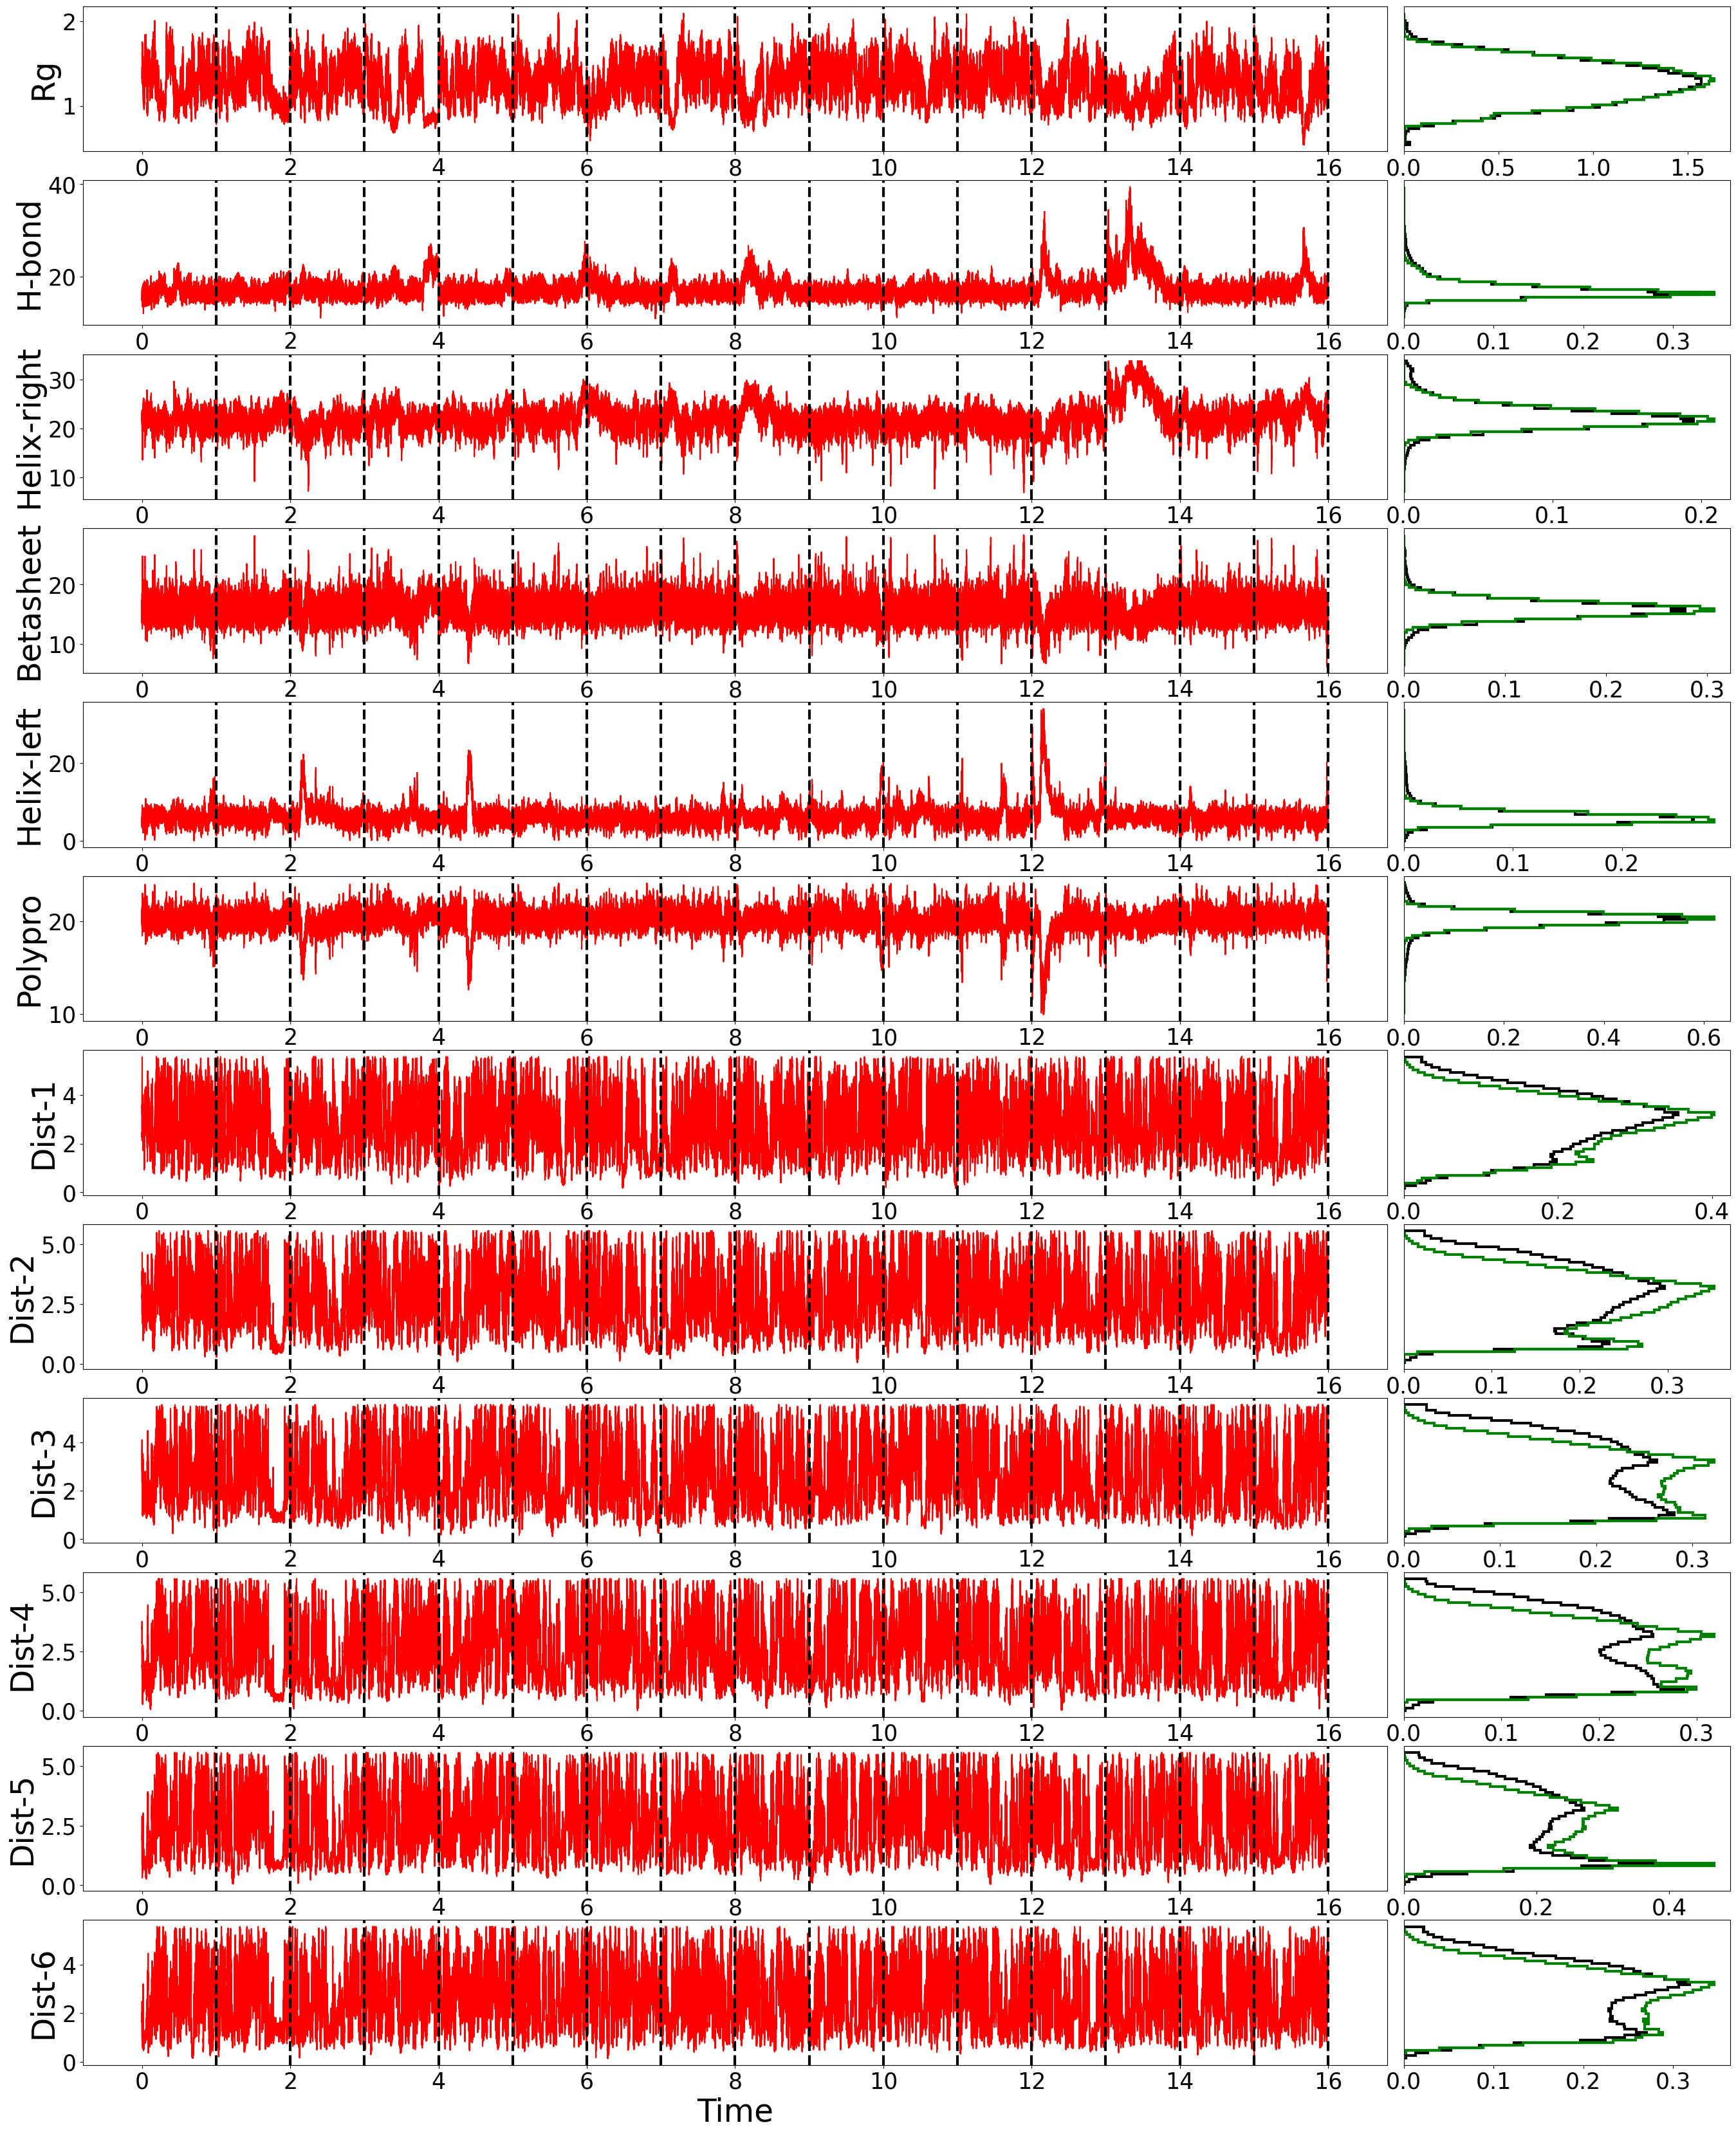

In [126]:

height_=[1]*(num_cvs_2-1)

label={'1':'Rg', '2':'H-bond', '3':'Helix-right', '4':'Betasheet', '5':'Helix-left', '6':'Polypro',
       '7':'Dist-1', '8':'Dist-2', '9':'Dist-3', '10':'Dist-4', '11':'Dist-5', '12':'Dist-6'}

f, ax = plt.subplots(num_cvs_2-1,2,figsize=(32,40),
                     gridspec_kw={'width_ratios':[4,1], 'height_ratios':height_, 'left':0.1, 'right':0.9, 
                                  'bottom':0.1, 'top':0.9,'wspace':0.02, 'hspace':0.2},sharey=False)

for i in range(num_cvs_2-1):
    

        
    ax[i,0].get_shared_y_axes().join(ax[i,0],ax[i,1])
    ax[i,0].plot(colvar['combined_2'].T[0]/10**5, colvar['combined_2'].T[i+1],color='r')
#    ax[i,0].set_ylim((min(colvar.T[i+1])-0.2),(max(colvar.T[i+1])+0.2))
    ax[i,0].set_ylabel(label[str(i+1)],size=35)
    ax[i,0].set_xlabel("Time",size=35)
    ax[i,0].tick_params(labelsize=25)
    
    for j in range(16):
        ax[i,0].axvline(x=trj_frames['combined_2'][j][1]/10**5, color='black', linewidth=3, linestyle='--')
    
    ax[i,1].hist(colvar['combined_2'].T[i+1],orientation='horizontal',bins=50,density=True,
                 color='black',histtype='step',linewidth=3)
    ax[i,1].hist(colvar['combined_2'].T[i+1],orientation='horizontal',bins=50,density=True,
                 color='green',histtype='step',linewidth=3,weights=weights_norm['combined_2'])
#    ax[i,1].set_xlim(0,0.7)
    ax[i,1].set_yticks([])
    ax[i,1].tick_params(labelsize=25)
    
#plt.tight_layout()

#plt.savefig(out_dir+'cv_plot.png',dpi=310)

plt.show()

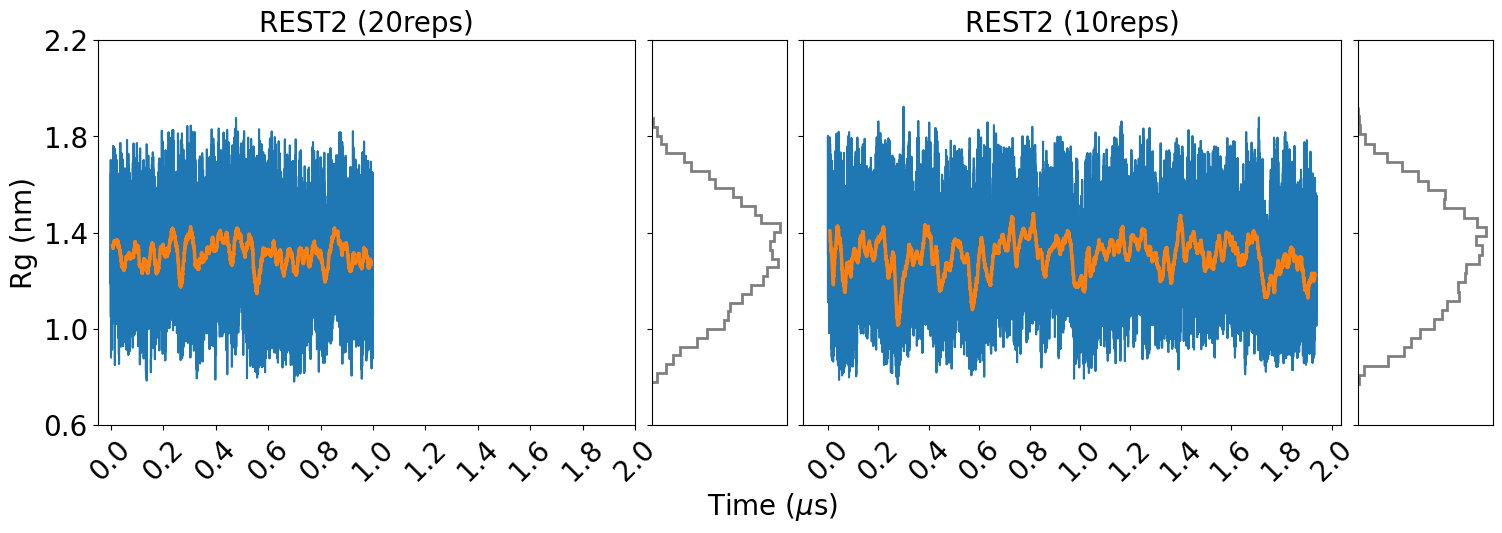

In [246]:
import matplotlib.pyplot as plt
import numpy as np

# Your data and setup
i = 'rep'
N = 200

# Create subplots with shared y-axis and adjusted widths
fig, (ax1, hist_ax1, ax2, hist_ax2) = plt.subplots(1, 4, figsize=(18, 5),sharey=True, gridspec_kw={'width_ratios': [4, 1, 4, 1]})

hist_axes = [hist_ax1, hist_ax2]
data_axes = [ax1, ax2]

for val in range(2):
    # Plot histograms on the left axes
    hist, bins, _ = hist_axes[val].hist(np.array(rg[val][i])[0], bins=30, alpha=0.5, orientation='horizontal', density=True, histtype='step',
                        color='black', lw=2)
    hist_axes[val].set_xticks([])
    # hist_axes[val].set_xticklabels(np.arange(0, 2,0.5) ,rotation=90 )
    # plt.setp(hist_axes[val].get_xticklabels(), rotation=90,ha='left' )
    # hist_axes[val].tick_params(axis='x', direction='in', labelrotation=90, labelleft=True)

    # tick_positions = np.arange(0, 1,0.5) ; tick_labels = np.arange(0, 2,0.5)
    # for pos, label in zip(tick_positions, tick_labels):
    #     hist_axes[val].text(pos, 0.01, label, rotation=90, ha='left', va='bottom', transform=hist_axes[val].transAxes)


    
    # Plot the data on the right axes
    data_axes[val].plot(time[val], np.array(rg[val][i])[0])
    data_axes[val].plot(np.convolve(time[val], np.ones(N)/N, mode='valid'),
                 np.convolve(np.array(rg[val][i])[0], np.ones(N)/N, mode='valid'), linewidth=2.5)
    
    data_axes[val].tick_params(labelsize=20)
    plt.setp(data_axes[val].get_xticklabels(), rotation=45)
    data_axes[val].set_ylim(0.6, 2.2)
    data_axes[val].set_yticks(np.arange(0.6, 2.5, 0.4))
    data_axes[val].set_title(title_[val], size=20)
    data_axes[val].set_xticks(np.arange(0, 2.2,0.2))

    if val == 0:
        data_axes[val].set_ylabel("Rg (nm)", size=20)  # Set y-axis label for data


fig.text(0.5, -0.07, 'Time ($\mu$s)', ha='center', size=20)

# Share x-axis between data axes ; Adjust the spacing between the axes
plt.subplots_adjust(wspace=0.05, hspace=0.1)
# Adjust the spacing of subplots
# plt.tight_layout()


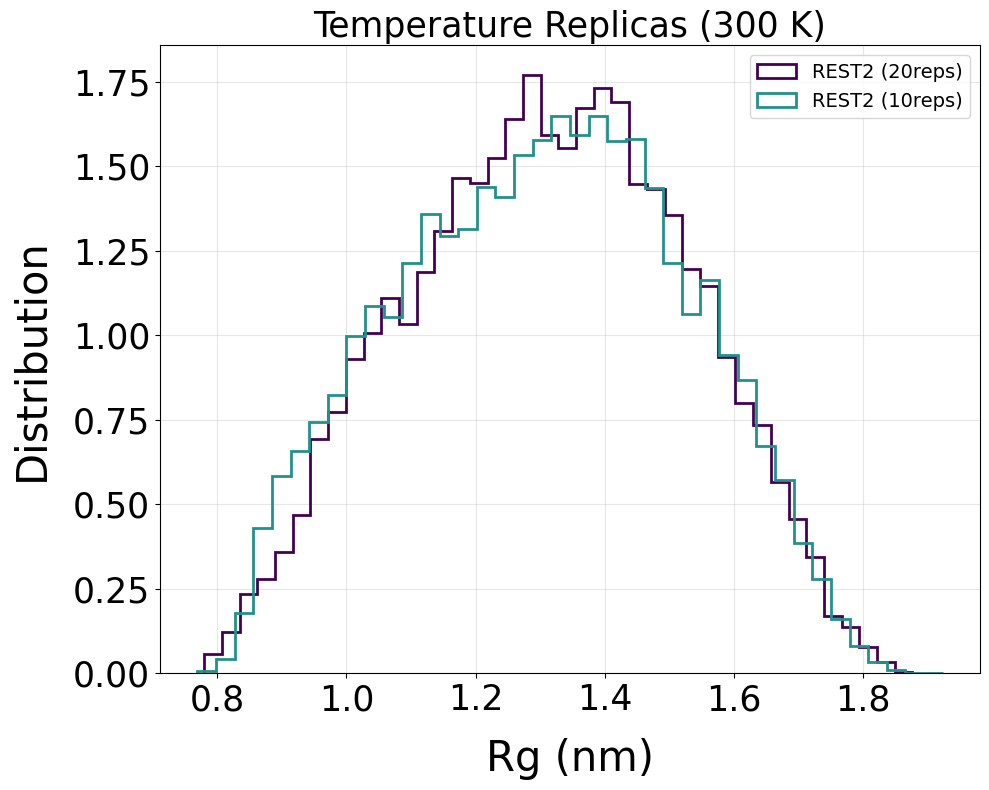

In [135]:
plt.figure(figsize=(10,8))

i='rep'

for val in range(2):
    if i=='rep': 
        label_=title_[val]  
    else:
        label_="Demux Replica - "+title_[val+1]
    
    plt.hist(np.array(rg[val][i])[0],bins=40,density=True,histtype='step',color=plt.cm.viridis(val/2),label=label_,lw=2)
    
    plt.tick_params(labelsize=25)
#     plt.setp(ax[val].get_xticklabels(), rotation=45)
    #ax[p,q].set_ylim(1,4)
    #ax[p,q].set_xticks(range(0,142,2))
    #ax[p,q].set_yticks(np.arange(1.0,4.0,0.4))
    
plt.title('Temperature Replicas (300 K)',size=25)
# plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=14) # bbox_to_anchor=(1, 0.5)
plt.ylabel("Distribution", size=30, labelpad=15)
plt.xlabel('Rg (nm)', size=30, labelpad=15)
plt.grid(alpha=0.3)       
plt.tight_layout()

# plt.savefig(data_dir+'rg_rep_hist_all.png',dpi=210)

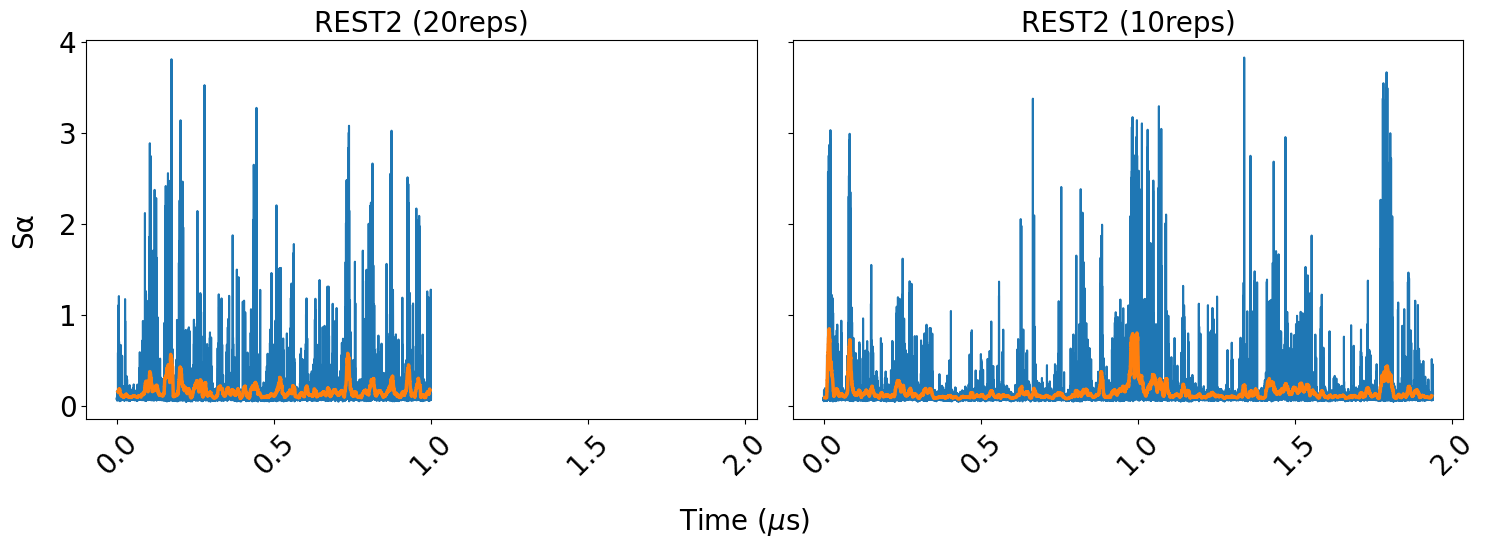

In [317]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

i='rep'
N=100

for val in range(2):

    p, q = np.unravel_index(val,(1, 2))
    
    X=np.sum(np.array(sa[val][i])[0],axis=0)
    
    ax[val].plot(time[val],X)
    ax[val].plot(np.convolve(time[val], np.ones(N)/N, mode='valid'),
                 np.convolve(X, np.ones(N)/N, mode='valid'),linewidth=2.5)
    
    ax[val].tick_params(labelsize=20)
    plt.setp(ax[val].get_xticklabels(), rotation=45)
    #ax[p,q].set_ylim(0.6,2.0)
    #ax[p,q].set_xticks(range(0,142,2))
    #ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[val].set_title(title_[val],size=20)

    if not q : ax[val].set_ylabel("Sα", size=20, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel('Time ($\mu$s)', size=20, labelpad=15)

fig.text(0.5, -0.07, 'Time ($\mu$s)', ha='center', size=20)

        
plt.tight_layout()


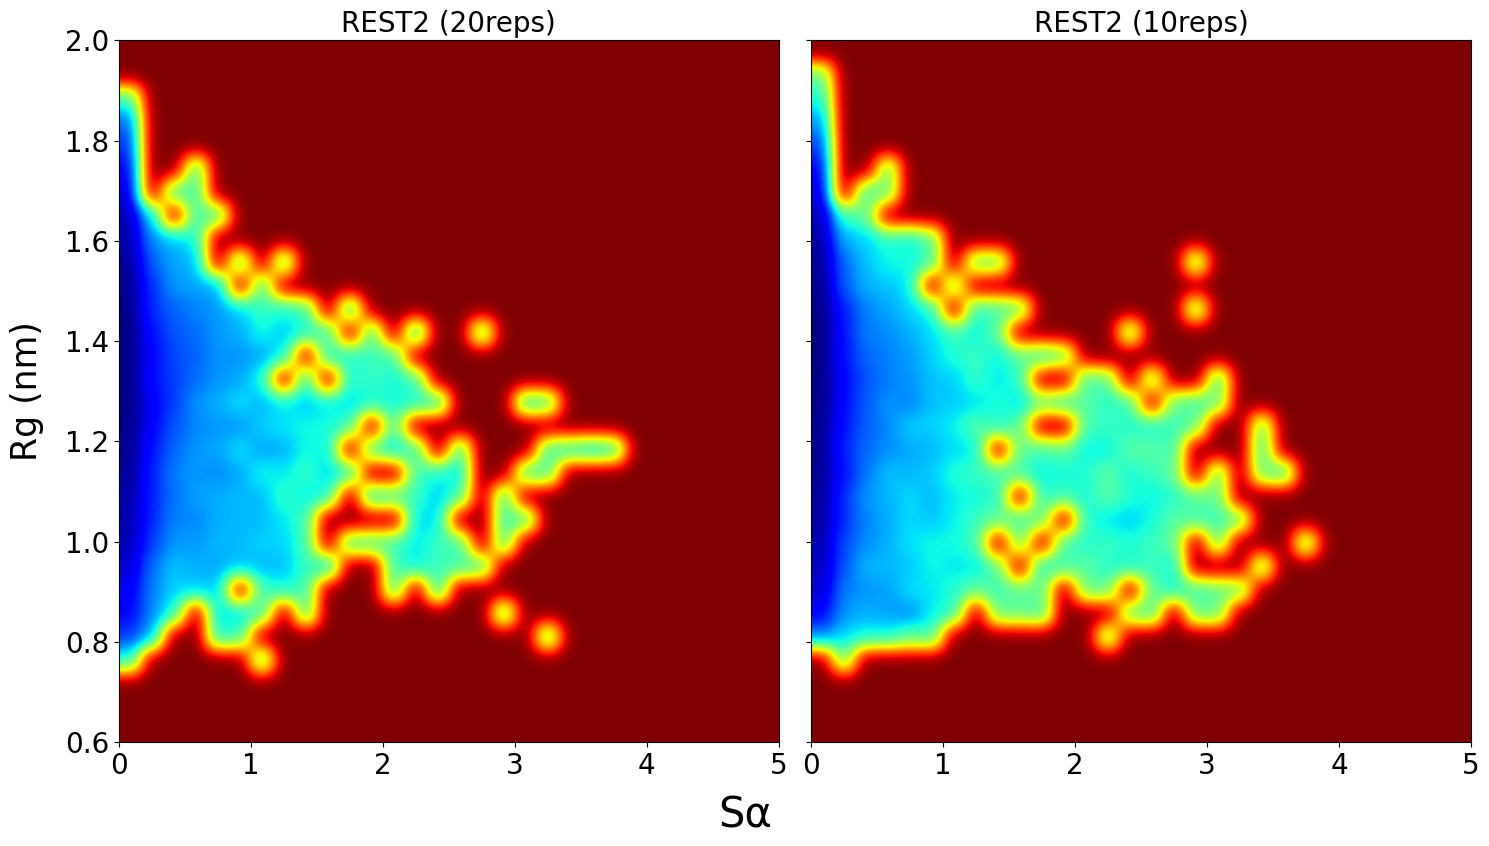

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

i='rep'

#cbar_ax = fig.add_axes([.91, .3, .03, .4])

for val in range(2):
    
    p, q = np.unravel_index(val,(1, 2))

    X=np.sum(np.array(sa[val][i])[0],axis=0)
    
    a, xedges, yedges = np.histogram2d(np.array(rg[val][i])[0], X, 30, [[0.6, 2.0], [0, 5.0]],
                                       density=True, weights=None)
    
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a
    

    im=subplot_imshow(a, xedges, yedges, ax=ax[val])
    
    
    cbar_ticks = [0, 1, 2, 3, 4, 5]
    # cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),aspect=10,cax=cbar_ax,ax=ax[val])
    
    #subplot_imshow(a, xedges, yedges,ax=ax[p,q],cbar_ax=cbar_ax,cbar=cb)
    
    imaxes = plt.gca()
    
    ax[val].tick_params(labelsize=20)
    #plt.setp(ax[p,q].get_xticklabels())
    ax[val].grid()
    #ax[p,q].set_ylim(0.6,2.0)
    #ax[p,q].set_xticks(range(0,142,2))
    #ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[val].set_title(title_[val],size=20)
    ax[val].grid(False)
    if not q : ax[val].set_ylabel('Rg (nm)', size=25, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel("Sα", size=25, labelpad=15)
        
fig.text(0.5, -0.04, "Sα", ha='center', size=30)

plt.tight_layout()

# plt.savefig(data_dir+'sa_rg_rep.png',dpi=210)
#plt.show()

In [145]:
aa={}

p=0
for i in data_dir[:-2]:
    
    aa[p]=json.load(open(i+'average_angle.json','r'))
    
    p+=1

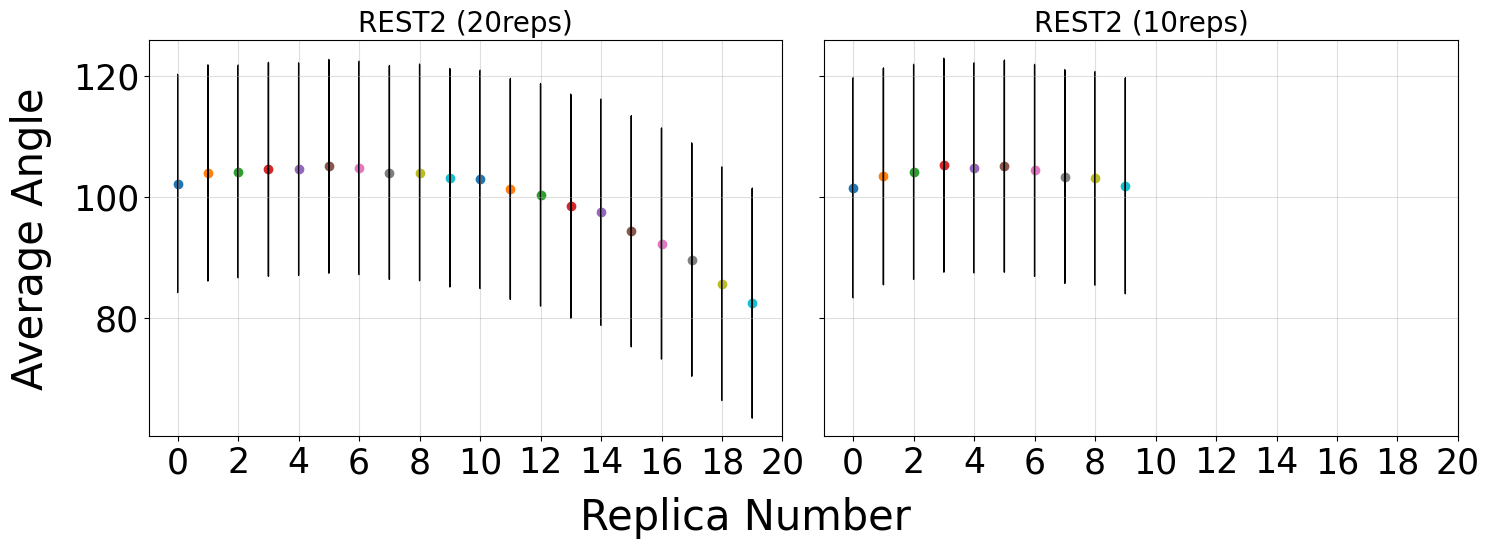

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True, sharex=True)

i='rep'

for val in range(2):
    p, q = np.unravel_index(val,(1, 2))
    
    for j in range(0,np.array(aa[val][i]).T[1].shape[0]):
        
        
        ax[val].scatter(np.array(aa[val][i]).T[0][j],np.array(aa[val][i]).T[1][j])
        ax[val].arrow(np.array(aa[val][i]).T[0][j],
                      (np.array(aa[val][i]).T[1]-(np.array(aa[val][i]).T[2]/2))[j],0,np.array(aa[val][i]).T[2][j])
    
    ax[val].tick_params(labelsize=25)
    plt.setp(ax[val].get_xticklabels(), rotation=0)
    #ax[p,q].set_ylim(0.6,2.0)
    ax[val].set_xticks(range(0,22,2))
    #ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[val].set_title(title_[val],size=20)

    if not q : ax[val].set_ylabel("Average Angle", size=30, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel('Replica Number', size=20, labelpad=15)
    
    ax[val].grid(alpha=0.4)

fig.text(0.5, -0.07, "Replica Number", ha='center', size=30)
    
plt.tight_layout()


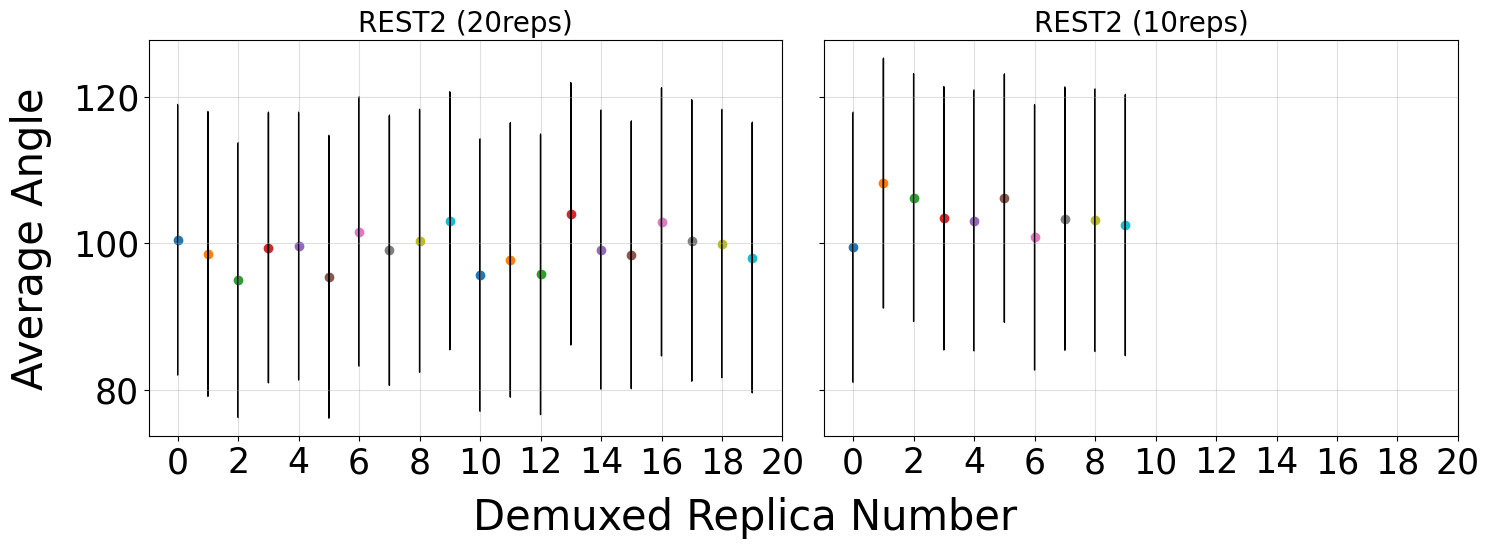

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True, sharex=True)

i='demux'

for val in range(2):
    p, q = np.unravel_index(val,(1, 2))
    
    for j in range(0,np.array(aa[val][i]).T[1].shape[0]):
        
        
        ax[val].scatter(np.array(aa[val][i]).T[0][j],np.array(aa[val][i]).T[1][j])
        ax[val].arrow(np.array(aa[val][i]).T[0][j],
                      (np.array(aa[val][i]).T[1]-(np.array(aa[val][i]).T[2]/2))[j],0,np.array(aa[val][i]).T[2][j])
    
    ax[val].tick_params(labelsize=25)
    plt.setp(ax[val].get_xticklabels(), rotation=0)
    #ax[p,q].set_ylim(0.6,2.0)
    ax[val].set_xticks(range(0,22,2))
    #ax[p,q].set_yticks(np.arange(0.6,2.2,0.4))
    
    ax[val].set_title(title_[val],size=20)

    if not q : ax[val].set_ylabel("Average Angle", size=30, labelpad=15)
    # if p == 1-1 : ax[val].set_xlabel('Replica Number', size=20, labelpad=15)
    
    ax[val].grid(alpha=0.4)

fig.text(0.5, -0.07, "Demuxed Replica Number", ha='center', size=30)
    
plt.tight_layout()


In [155]:
data_dir

['/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas_20reps/',
 '/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas/',
 '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas/',
 '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas_1/']

In [156]:
charge={}
hphob={}
aro={}
hbond={}
contact={}

p=0
for i in data_dir:
    
    if p>=2 : 
        
        charge[p]=json.load(open(i+'charge_prob_combined.json','r'))
        hphob[p]=json.load(open(i+'hphob_prob_combined.json','r'))
        aro[p]=json.load(open(i+'aro_prob_combined.json','r'))
        hbond[p]=json.load(open(i+'hbond_prob_combined.json','r'))
        contact[p]=json.load(open(i+'contact_prob_combined.json','r'))
        
    else :
        
        charge[p]=json.load(open(i+'charge_prob.json','r'))
        hphob[p]=json.load(open(i+'hyphob_prob.json','r'))
        aro[p]=json.load(open(i+'aro_prob.json','r'))
        hbond[p]=json.load(open(i+'hbond_prob.json','r'))
        contact[p]=json.load(open(i+'contact_prob.json','r'))
    
    p+=1

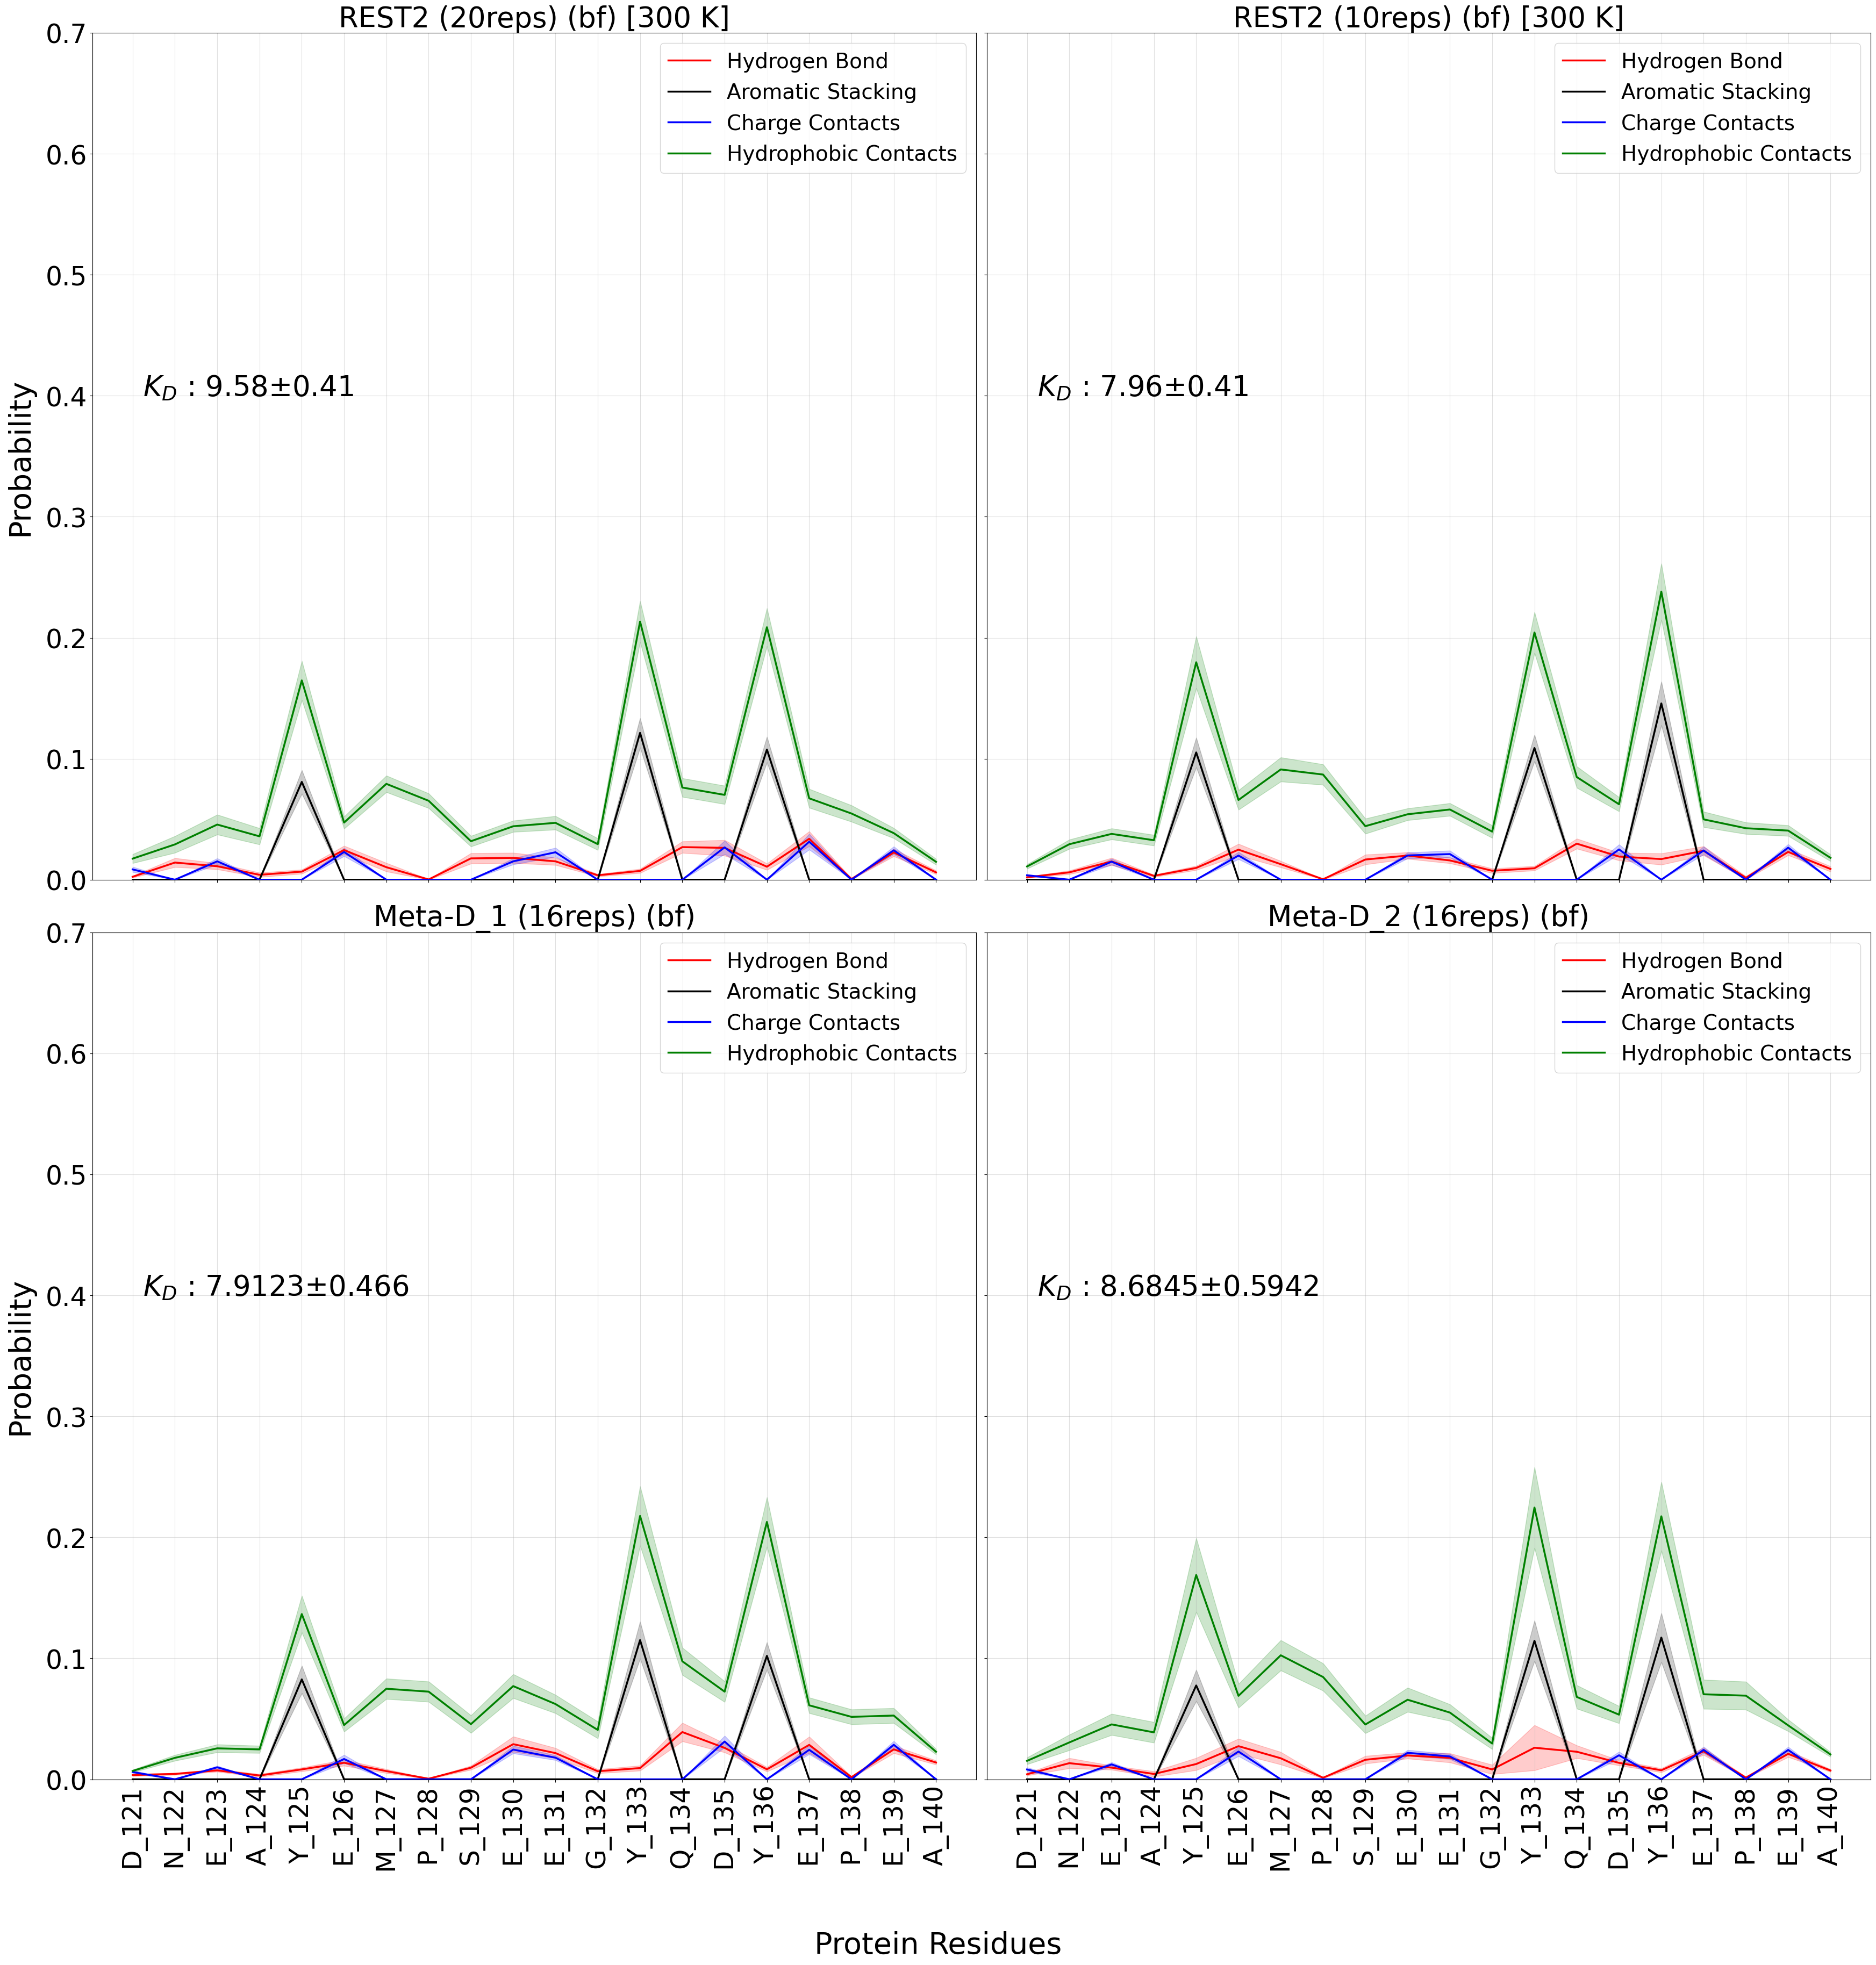

In [200]:
fig, ax = plt.subplots(2, 2, figsize=(35, 35), sharex=True, sharey=True)

i='rep'
val=0
# k=['all','bf']
k='bf'
l=0
kd_md={ 'kd' : [7.9123,8.6845] , 'kd_e' : [0.466,0.5942]}

for j in range(4):
    
    p,q = np.unravel_index(j,(2, 2))
    
        
    if p==1 and q<=1 :
        
        ax[p, q].plot(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(hbond[l]['bf']['re']).T[0][:-1], linewidth=2.5,
                             label='Hydrogen Bond', color='red')
        ax[p, q].fill_between(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(hbond[l]['bf']['re']).T[0][:-1]-np.array(hbond[l]['bf']['re']).T[1][:-1],
                                 np.array(hbond[l]['bf']['re']).T[0][:-1]+np.array(hbond[l]['bf']['re']).T[1][:-1], alpha=0.2,color='r')


        ax[p, q].plot(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(aro[l]['bf']['re']).T[0][:-1], linewidth=2.5,
                             color='black', label='Aromatic Stacking')
        ax[p, q].fill_between(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(aro[l]['bf']['re']).T[0][:-1]-np.array(aro[l]['bf']['re']).T[1][:-1],
                                 np.array(aro[l]['bf']['re']).T[0][:-1]+np.array(aro[l]['bf']['re']).T[1][:-1], alpha=0.2,color='black')

        ax[p, q].plot(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(charge[l]['bf']['re']).T[0][:-1], linewidth=2.5,
                             label='Charge Contacts',c='blue')
        ax[p, q].fill_between(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(charge[l]['bf']['re']).T[0][:-1]-np.array(charge[l]['bf']['re']).T[1][:-1],
                                 np.array(charge[l]['bf']['re']).T[0][:-1]+np.array(charge[l]['bf']['re']).T[1][:-1], alpha=0.2,color='b')

        ax[p, q].plot(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(hphob[l]['bf']['re']).T[0][:-1], linewidth=2.5,
                             label='Hydrophobic Contacts', color='green')
        ax[p, q].fill_between(np.array(hbond[0]['rep']['bf'][0]).T[0], np.array(hphob[l]['bf']['re']).T[0][:-1]-np.array(hphob[l]['bf']['re']).T[1][:-1],
                                 np.array(hphob[l]['bf']['re']).T[0][:-1]+np.array(hphob[l]['bf']['re']).T[1][:-1], alpha=0.2,color='g')
        
        
        ax[p, q].set_ylim(0,0.7)
        ax[p, q].set_xticks(range(121,141),b[::])
        ax[p,q].tick_params(labelsize=35)
        ax[p,q].grid(alpha=0.4)
        plt.setp(ax[p,q].get_xticklabels(), rotation=90)

        if val == 0:
            ax[p,q].legend(loc=1,prop={'size': 28})
            
        a=title_[q+2]+' ('+str(k)+')'
        ax[p,q].set_title(a,size=38)
        
        text_=r'$K_{D}$'+' : '+str(kd_md['kd'][q])+r'$\pm$'+str(kd_md['kd_e'][q])
        ax[p,q].text(121.25, 0.4, text_, fontsize = 38)
    
    elif p==2 and q==1 : continue
        
    else:
        
        
        ax[p, q].plot(np.array(hbond[l][i][k][val]).T[0], np.array(hbond[l][i][k][val]).T[1], linewidth=2.5,
                             label='Hydrogen Bond', color='red')
        ax[p, q].fill_between(np.array(hbond[l][i][k][val]).T[0], np.array(hbond[l][i][k][val]).T[1]-np.array(hbond[l][i][k][val]).T[2],
                                 np.array(hbond[l][i][k][val]).T[1]+np.array(hbond[l][i][k][val]).T[2], alpha=0.2,color='r')


        ax[p, q].plot(np.array(aro[l][i][k][val]).T[0], np.array(aro[l][i][k][val]).T[1], linewidth=2.5,
                             color='black', label='Aromatic Stacking')
        ax[p, q].fill_between(np.array(aro[l][i][k][val]).T[0], np.array(aro[l][i][k][val]).T[1]-np.array(aro[l][i][k][val]).T[2],
                                 np.array(aro[l][i][k][val]).T[1]+np.array(aro[l][i][k][val]).T[2], alpha=0.2,color='black')

        ax[p, q].plot(np.array(charge[l][i][k][val]).T[0], np.array(charge[l][i][k][val]).T[1], linewidth=2.5,
                             label='Charge Contacts',c='blue')
        ax[p, q].fill_between(np.array(charge[l][i][k][val]).T[0], np.array(charge[l][i][k][val]).T[1]-np.array(charge[l][i][k][val]).T[2],
                                 np.array(charge[l][i][k][val]).T[1]+np.array(charge[l][i][k][val]).T[2], alpha=0.2,color='b')

        ax[p, q].plot(np.array(hphob[l][i][k][val]).T[0], np.array(hphob[l][i][k][val]).T[1], linewidth=2.5,
                             label='Hydrophobic Contacts', color='green')
        ax[p, q].fill_between(np.array(hphob[l][i][k][val]).T[0], np.array(hphob[l][i][k][val]).T[1]-np.array(hphob[l][i][k][val]).T[2],
                                 np.array(hphob[l][i][k][val]).T[1]+np.array(hphob[l][i][k][val]).T[2], alpha=0.2,color='g')
    
    
        
        ax[p, q].set_ylim(0,0.7)
        ax[p, q].set_xticks(range(121,141),b[::])
        ax[p,q].tick_params(labelsize=35)
        ax[p,q].grid(alpha=0.4)
        plt.setp(ax[p,q].get_xticklabels(), rotation=90)

        if val == 0:
            ax[p,q].legend(loc=1,prop={'size': 28})
            
        a=title_[l]+' ('+str(k)+')'+' [300 K]'
        ax[p,q].set_title(a,size=38)
        
#         text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[l]['rep'])[2][0],2))+\
#         r'$\pm$'+str(round(np.array(bf_kd[l][i])[3][0],2))
#         ax[p,q].text(121.25, 0.4, text_, fontsize = 38)
    
        if l <= 2 :

            text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[l]['rep'])[2][0][0],2))+\
            r'$\pm$'+str(round(np.array(bf_kd[l]['rep'])[3][0][0],2))
        else :
            text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[l]['rep'])[2][0][0],2))+\
            r'$\pm$'+str(round(np.array(bf_kd[l]['rep'])[3][0][0],2))
        ax[p,q].text(121.25, 0.4, text_, fontsize = 38)
            
    l+=1
        
        
    if not q : ax[p,q].set_ylabel("Probability", size=40, labelpad=15)
    # if p == 2-1 : ax[p,q].set_xlabel('Protein Residues', size=40, labelpad=15)

fig.text(0.5, -0.04, "Protein Residues", ha='center', size=40)
    
plt.tight_layout()

In [217]:
plt.rcParams['text.usetex'] = False

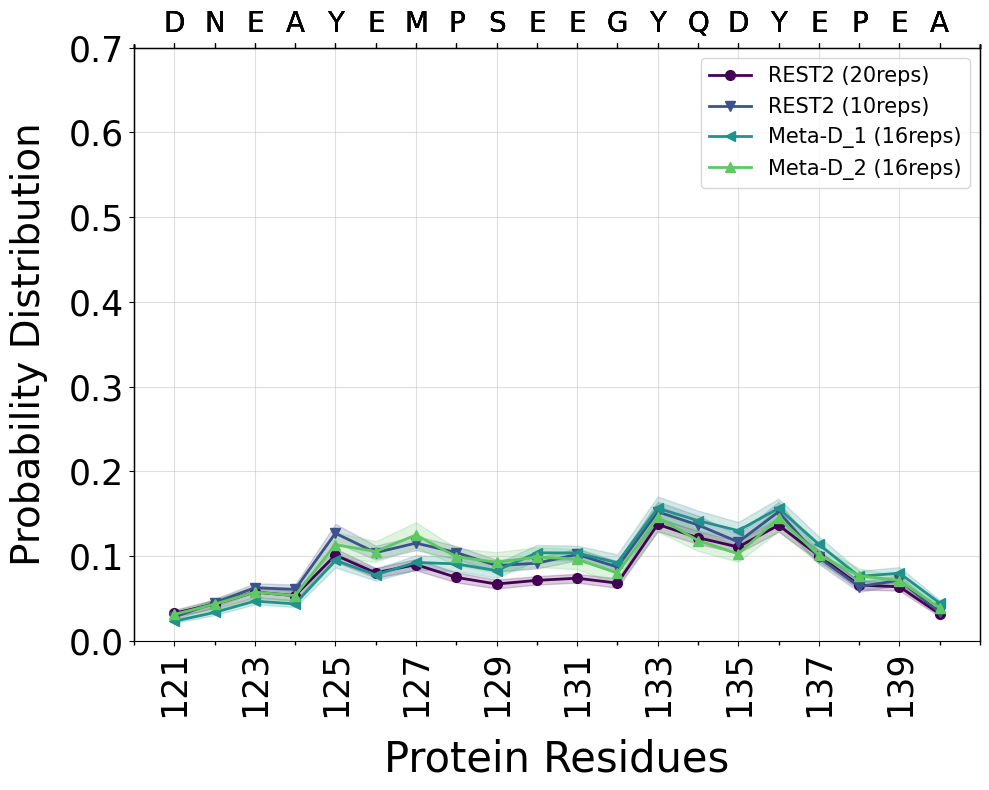

In [219]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
marker=['o','v','<','^','>']
yl=r'Probability Distribution'

for i in range(4):
    
    if i<2 :
        
        axes.plot(np.array(contact[i]['rep'][0]).T[0],np.array(contact[i]['rep'][0]).T[1],linestyle='-',
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/4), lw=2, ms=7,label=title_[i])
        axes.fill_between(np.array(contact[i]['rep'][0]).T[0], np.array(contact[i]['rep'][0]).T[1]-np.array(contact[i]['rep'][0]).T[2],
                     np.array(contact[i]['rep'][0]).T[1]+np.array(contact[i]['rep'][0]).T[2], color=plt.cm.viridis(i/4), alpha=0.2)
    else :
        
        axes.plot(np.array(contact[0]['rep'][0]).T[0],np.array(contact[i]['all']['re']).T[0],linestyle='-',
                 marker=marker[i % len(marker)],color=plt.cm.viridis(i/4), lw=2, ms=7,label=title_[i])
        axes.fill_between(np.array(contact[0]['rep'][0]).T[0], np.array(contact[i]['all']['re']).T[0]-np.array(contact[i]['all']['re']).T[1],
                     np.array(contact[i]['all']['re']).T[0]+np.array(contact[i]['all']['re']).T[1], color=plt.cm.viridis(i/4), alpha=0.2)
    
    axes.tick_params(labelsize=25)
    axes.grid(alpha=0.4)
    plt.setp(axes.get_xticklabels(), rotation=90)
    axes.set_ylim(0,0.7)
    axes.set_xlim(120,141)
    # ax[val].set_xticks(range(121,141,2), b[::2])
    axes.set_xticks(range(121,141,2), range(121,141,2),rotation=90)
    axes.legend( fontsize=15) 
    axes.set_ylabel(yl, size=28, labelpad=15)
    axes.set_xlabel('Protein Residues', size=30, labelpad=15)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    axes.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')

    ax2 = axes.twiny()

    # Set custom labels for the top x-axis
    top_labels = c[::2]
    top_tick_positions = range(0, 20, 2)

    # Use invisible spines and set labels for the top x-axis
    ax2.spines['top'].set_position(('outward', 0))
    ax2.spines['top'].set_visible(True)
    ax2.spines['bottom'].set_position(('outward', 0))
    ax2.spines['bottom'].set_visible(False)
    ax2.set_xlim(120,141)
    ax2.set_xticks(range(121,141), c[::])
    # ax2.set_xticklabels(top_labels)
    ax2.tick_params(axis='x', labelsize=20)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax2.tick_params(axis='x', which='minor', length=3, width=1, color='k', direction='out')
 

    
#     text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd['rep'])[2][val],2))+r'$\pm$'+str(round(np.array(bf_kd['rep'])[3][val],2))
#     ax[p,q].text(120.3, 0.63, text_, fontsize = 28)
    
plt.tight_layout()
# plt.savefig(data_dir+'ss_fraction_helix_rep.png',dpi=210)

In [220]:
data_dir

['/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas_20reps/',
 '/home/jaya/work/ANALYSIS_3JAN/rest_1us/data_fas/',
 '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas/',
 '/data/Jaya_Krishna/analysis_trajectories/async/meta_D_20bf/data/fas_1/']

In [221]:
data={}
file_list=['/home/jaya/work/ANALYSIS_3JAN/rest_1us/xvg/af_20reps_temp.xvg',
          '/home/jaya/work/ANALYSIS_3JAN/rest_1us/xvg/af_10reps_temp.xvg']

for i in range(2):
    
    data[i]=np.loadtxt(file_list[i],comments=['@','#'])
    

In [222]:
data[0].T

array([[0.000000e+00, 1.600000e+00, 3.200000e+00, ..., 9.999952e+05,
        9.999968e+05, 9.999984e+05],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.400000e+01,
        1.400000e+01, 1.500000e+01],
       [1.000000e+00, 1.000000e+00, 2.000000e+00, ..., 1.800000e+01,
        1.800000e+01, 1.800000e+01],
       ...,
       [1.700000e+01, 1.600000e+01, 1.600000e+01, ..., 2.000000e+00,
        2.000000e+00, 2.000000e+00],
       [1.800000e+01, 1.900000e+01, 1.900000e+01, ..., 1.000000e+01,
        1.000000e+01, 1.100000e+01],
       [1.900000e+01, 1.800000e+01, 1.700000e+01, ..., 5.000000e+00,
        5.000000e+00, 5.000000e+00]])

In [223]:
prob={}

for j in range(2):
    nrep=data[j].shape[1]-1
    prob[j]=[]
    b=0
    
    for i in range(nrep):
        a=(np.where(data[j].T[i+1]==0)[0].shape[0])/(data[j].shape[0])
        prob[j].append(a)
#         print(i,a)
        b=b+a
    print(f'Probability check : {b}')
    print("\n")


Probability check : 1.0


Probability check : 1.0




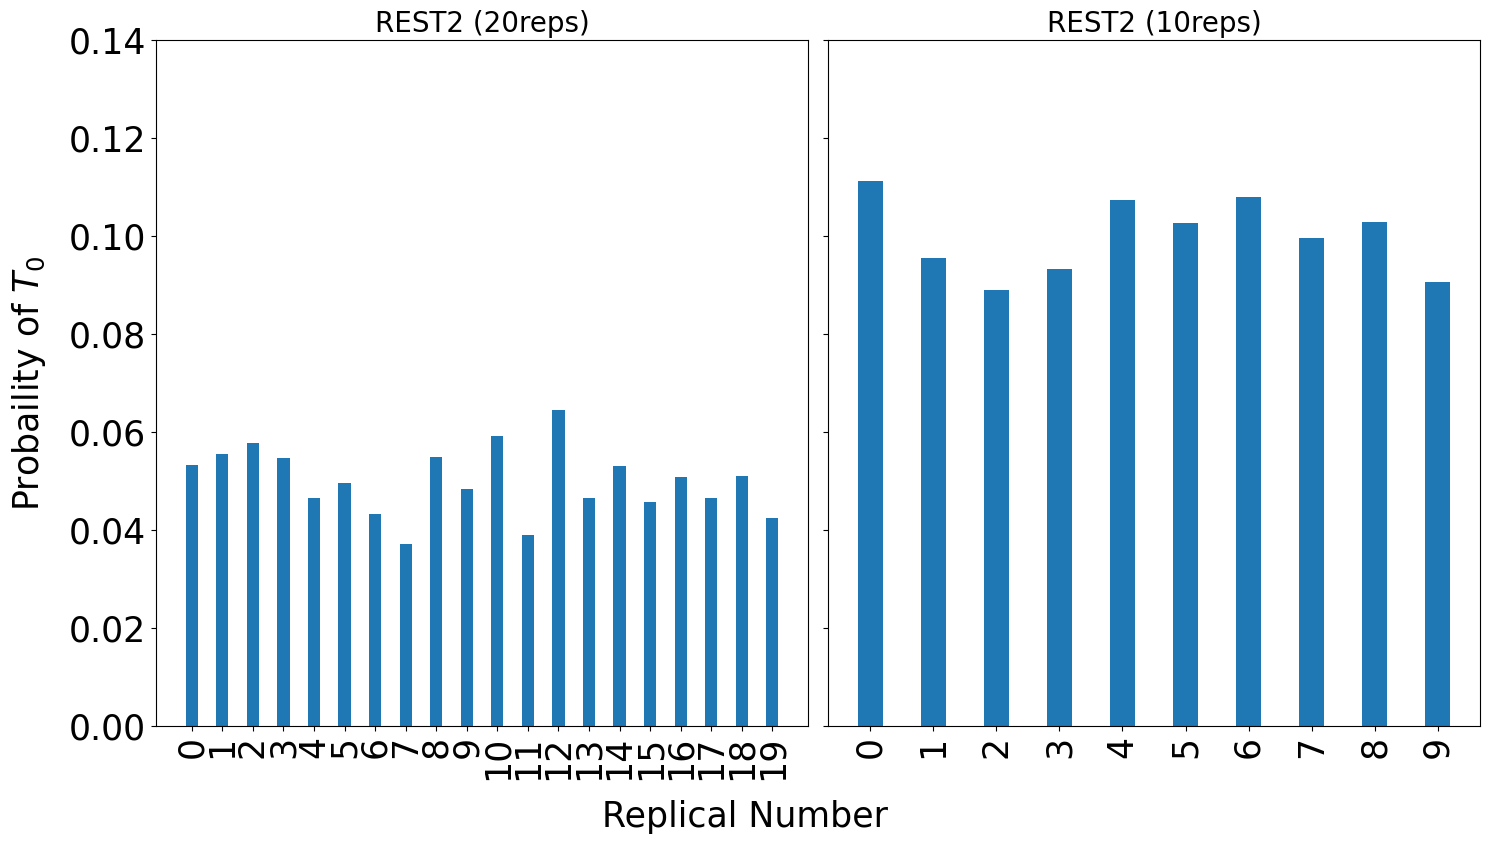

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i in range(2):
    p, q = np.unravel_index(i,(1,2))
    nrep=data[i].shape[1]-1
    
    ax[i].bar(range(nrep),prob[i],width = 0.4)
    ax[i].tick_params(labelsize=25)
    ax[i].set_xticks(range(nrep), range(nrep), rotation=90)
    ax[i].set_yticks(np.arange(0,0.16,0.02))
    ax[i].set_title(title_[i],size=20)
    
    
#     if i <= 2 :

#         text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[i]['rep'])[2][0],2))+\
#         r'$\pm$'+str(round(np.array(bf_kd[i]['rep'])[3][0],2))
#     else :
#         text_=r'$K_{D}$'+' : '+str(round(np.array(bf_kd[i]['rep'])[2][0][0],2))+\
#         r'$\pm$'+str(round(np.array(bf_kd[i]['rep'])[3][0][0],2))
    
#     ax[i].text(0.25, 0.16, text_, fontsize = 18)
    
    if not q : ax[i].set_ylabel(r'Probaility of $T_{0}$',size=25, labelpad=15)
    # if p == 2-1 : ax[i].set_xlabel('Replical Number',size=20, labelpad=15)

fig.text(0.5, -0.04, "Replical Number", ha='center', size=25)

        
plt.tight_layout()

In [227]:
temperature={}

temperature[0] = [ 300,311.147,322.707,334.697,347.133,360.031,373.408,387.282,401.671,416.595,
                  432.074,448.128,464.778,482.047,499.957,518.533,537.799,557.781,578.506,600 ]
temperature[1]=[ 300,313.825,328.286,343.414,359.239,375.794,393.111,411.227,430.177,450 ]



In [228]:
T_mean={}

for i in range(2):
    
    nrep=data[i].shape[1]-1
    T=[]
    
    for j in range(1,nrep+1):
        
        replica_T=[]
        for k in data[i].T[j]:
            replica_T.append(temperature[i][int(k)])
            
        T.append(np.mean(replica_T))
        
    T_mean[i]=T

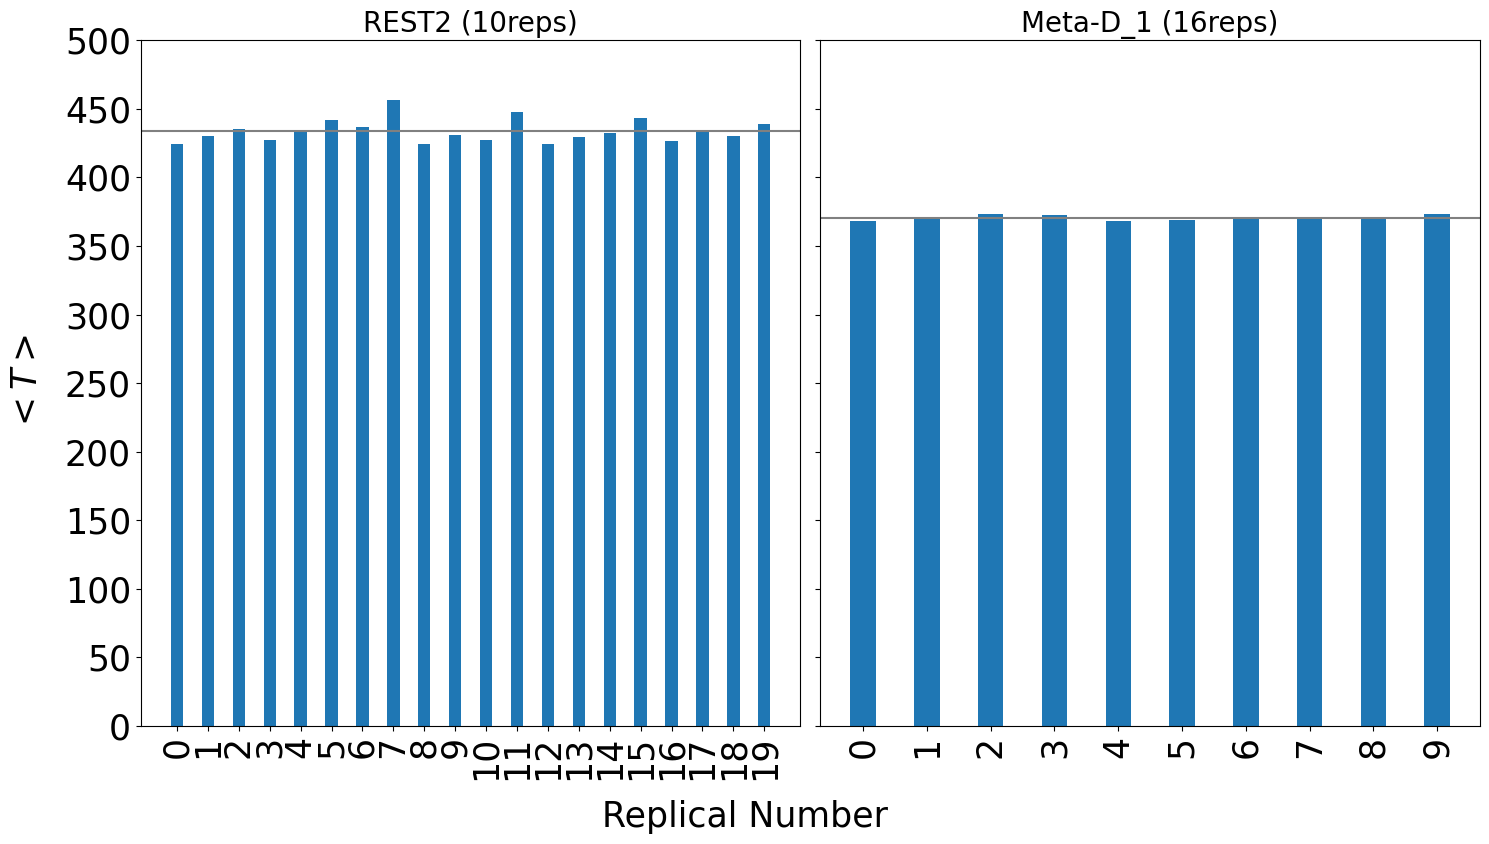

In [231]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i in range(2):
    p, q = np.unravel_index(i,(1,2))
    
    nrep=data[i].shape[1]-1
    
    ax[i].bar(range(nrep),T_mean[i],width = 0.4)
    ax[i].axhline(y=np.mean(T_mean[i]),color='grey')
    ax[i].tick_params(labelsize=25)

    ax[i].set_xticks(range(nrep), range(nrep), rotation=90)
    ax[i].set_yticks(np.arange(0,550,50))
    ax[i].set_title(title_[i+1],size=20)
    
    if not q : ax[i].set_ylabel(r'$<T>$',size=25, labelpad=15)
    # if p == 2-1 : ax[i].set_xlabel('Replical Number',size=20, labelpad=15)

fig.text(0.5, -0.04, "Replical Number", ha='center', size=25)
    
        
plt.tight_layout()

In [233]:
# calculate round trip times stack
def calc_round_trip_stack(file, nreps = 20 ):
    """
    xvg = the temp xvg file with the exchanges at every 80ps
    """
    # unpack the xvg file 
    rep_dict = {} # for counting 
    xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in range(nreps): 
        rep = xvg[:,i]
        rep_dict[i] = 0 
        stack = []
        for e in rep:
            # reinstantiate list 
            if len(stack) == nreps: 
                rep_dict[i] += 0.5
                stack = []
            elif int(e) not in stack: 
                stack.append(int(e))
    
    return rep_dict

# Old Rt code
def calc_round_trip_stack_2(file, nreps=20):
    
    n=0
    d=0
    # rt=0
    rep_dict={}
    rep=[i for i in range(nreps)]

    data=np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in rep:
        rep_dict[i] = 0
        stack = []

        for e in data.T[i]:

            n+=1
            if int(e) not in stack:
                stack.append(int(e))
                
            if e == nreps-1:
                d=1
                
            if e == 0 and d == 1:
                
                d=0
                rep_dict[i]+=1
                stack = []
                
    return rep_dict


In [234]:
nreps=[20,10]

file_list=['/home/jaya/work/ANALYSIS_3JAN/rest_1us/xvg/af_20reps_temp.xvg',
          '/home/jaya/work/ANALYSIS_3JAN/rest_1us/xvg/af_10reps_temp.xvg']

In [235]:
rt_dict={}
for i in range(2):
    
    rt_dict[i]=calc_round_trip_stack(file_list[i],nreps=nreps[i])

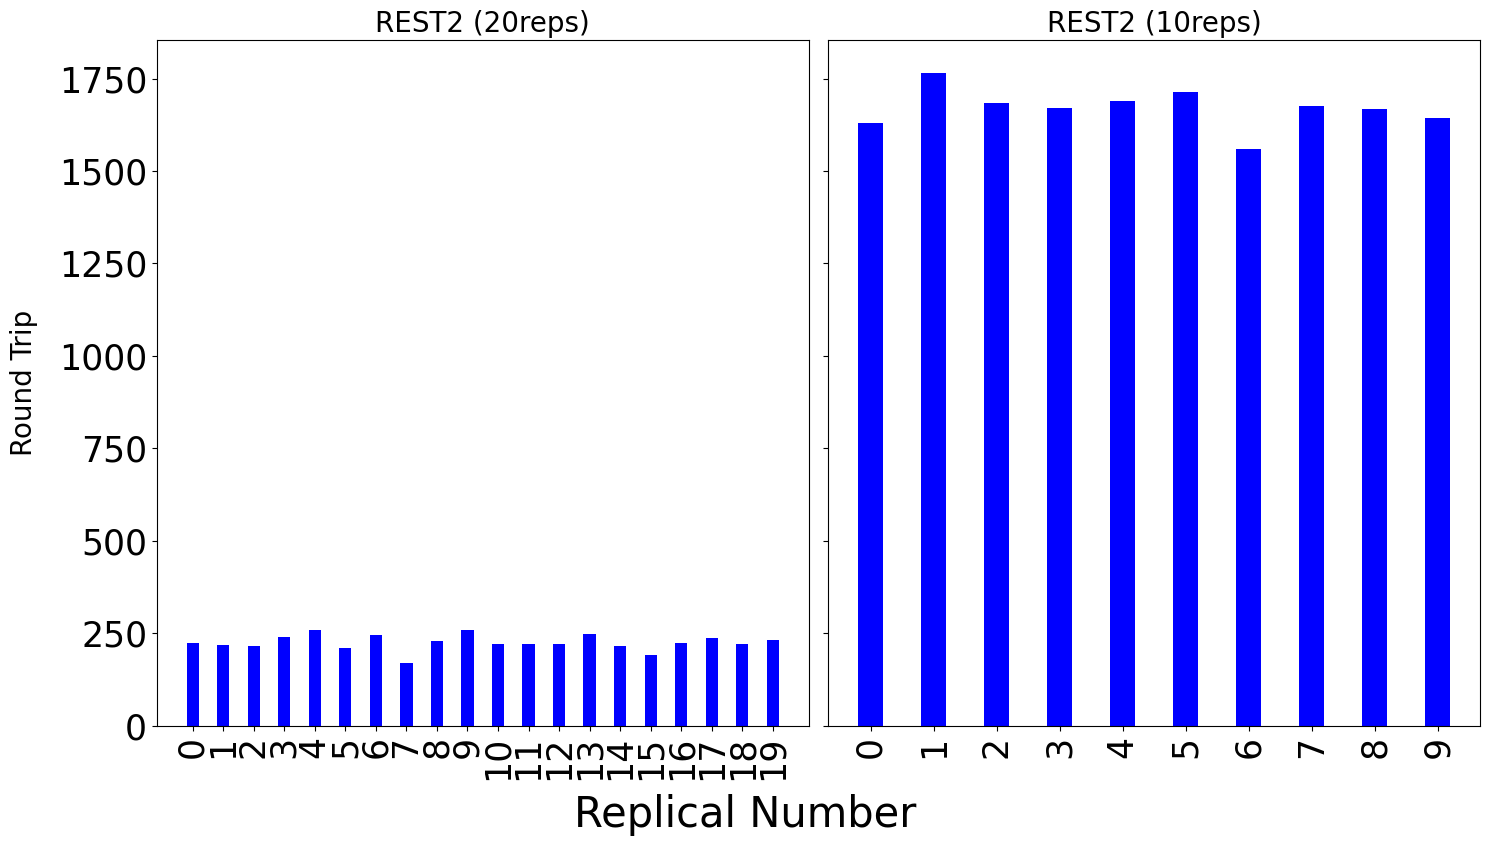

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i in range(2):
    p, q = np.unravel_index(i,(1,2))
    
    nrep=data[i].shape[1]-1
    
    for j in range(nrep):
        
        ax[i].bar(j,rt_dict[i][j],width = 0.4,color='b')
#     ax[p, q].axhline(y=np.mean(rt_dict[i]),color='grey')
    ax[i].set_xticks(range(nrep), range(nrep), rotation=90)
    ax[i].tick_params(labelsize=25)

#     ax[i].set_yticks(np.arange(0,550,50),size=35)
    ax[i].set_title(title_[i],size=20)
    
    
    if not q : ax[i].set_ylabel(r'Round Trip',size=20, labelpad=15)
    # if p == 2-1 : ax[i].set_xlabel('Replical Number',size=20, labelpad=15)

fig.text(0.5, -0.04, "Replical Number", ha='center', size=30)

        
plt.tight_layout()

In [238]:
rt_dict={}
for i in range(2):
    
    rt_dict[i]=calc_round_trip_stack_2(file_list[i],nreps=nreps[i])

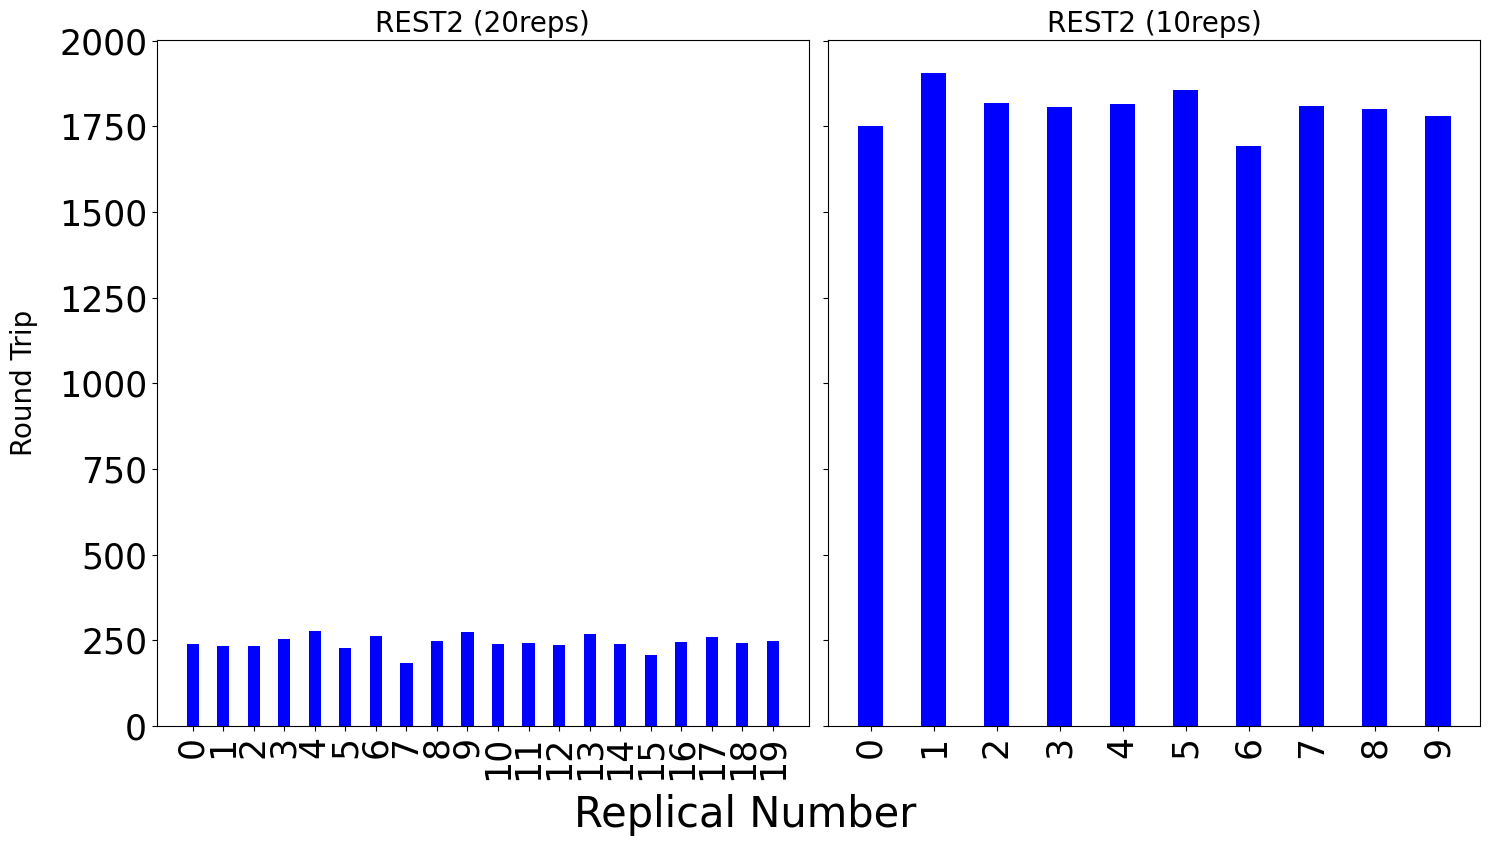

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i in range(2):
    p, q = np.unravel_index(i,(1,2))
    
    nrep=data[i].shape[1]-1
    
    for j in range(nrep):
        
        ax[i].bar(j,rt_dict[i][j],width = 0.4,color='b')
#     ax[p, q].axhline(y=np.mean(rt_dict[i]),color='grey')
    ax[i].set_xticks(range(nrep), range(nrep), rotation=90)
#     ax[i].set_yticks(np.arange(0,550,50),size=35)
    ax[i].set_title(title_[i],size=20)
    ax[i].tick_params(labelsize=25)
    
    
    if not q : ax[i].set_ylabel(r'Round Trip',size=20, labelpad=15)
    # if p == 2-1 : ax[i].set_xlabel('Replical Number',size=20, labelpad=15)

fig.text(0.5, -0.04, "Replical Number", ha='center', size=30)

        
plt.tight_layout()